# Forecasting Bergen City Bike Demand
### Historical Analysis & Time Series Analysis 
### Personal Project By: Alana Ahart 


## What the project is about: 
I recently visited Bergen, Norway, and before I went, I thought it would be interesting to complete a project that might help me learn something about the city that I wouldn’t know otherwise. Bergen City Bike is the bike sharing company in Bergen, offering rentals similar to Lime and Bird in the US. I collected rider data made available by the company from 2022–2024 to analyze historical ride patterns and predict future demand using time series analysis.

## Why it matters: 
Accurately predicting bike demand helps ride sharing companies optimize bike distribution, reduce shortages or surpluses at stations, and improve the overall customer experience. These insights can guide operational planning and resource allocation.

## Tools & Methods: 
- Time Series Models: Prophet, Holt-Winters
- Programming & Analysis: Python (Jupyter Notebook, Google Colab)
- Data Handling & Visualization: pandas, matplotlib

## Project Objectives
- Analyze historical bike ride data
- Forecast future demand using time series analysis 

## How to Run This Notebook
- All data is stored in the `data/` folder as ZIPs
- The notebook uses relative paths and runs in Google Colab or locally
- No external credentials or setup required


### Data Loading & Preprocessing 

Load libraries 

In [1]:
!pip install prophet neuralprophet plotly
!pip install folium 


In [4]:
import folium
from neuralprophet import NeuralProphet


Importing plotly failed. Interactive plots will not work.
Importing plotly failed. Interactive plots will not work.


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import glob
import os
import networkx as nx

In [8]:

from statsmodels.tsa.holtwinters import ExponentialSmoothing
from sklearn.metrics import mean_absolute_error, mean_squared_error
from itertools import product
from statsmodels.tsa.seasonal import STL
from prophet.diagnostics import cross_validation, performance_metrics
import itertools


Load files and combine into Dataframe. 

In [10]:
import requests
from io import BytesIO
import zipfile

In [26]:


# Base GitHub URL to your data folder
base_url = 'https://github.com/alanaahart/bergen-city-bike-forecasting/raw/main/data/'

# List of ZIP filenames
months = [
    'SeptemberRides.zip','OctoberRides.zip','NovRides.zip','DecRides.zip',
    'JanuaryRides.zip','FebRides.zip','MarchRides.zip','AprRides.zip',
    'MayRides.zip','JuneRides.zip','JulyRides.zip','AugustRides.zip'
]

# Initialize empty DataFrame and file counter
df_all = pd.DataFrame()
file_count = 0

# Loop through each ZIP file
for zip_name in months:
    url = base_url + zip_name
    response = requests.get(url)
    
    if response.status_code == 200:
        with zipfile.ZipFile(BytesIO(response.content)) as zip_ref:
            # Filter out hidden/system files and keep only CSVs
            csv_files = [f for f in zip_ref.namelist() if f.endswith('.csv') and not f.startswith('__MACOSX')]
            print(f"{zip_name}: {len(csv_files)} CSV files")

            for csv_name in csv_files:
                file_count += 1
                try:
                    with zip_ref.open(csv_name) as file:
                        df = pd.read_csv(file)  # Try UTF-8
                except UnicodeDecodeError:
                    with zip_ref.open(csv_name) as file:
                        df = pd.read_csv(file, encoding='ISO-8859-1')  # Fallback

                # Tag source info
                df['source_month'] = zip_name.replace('.zip', '')
                df['source_file'] = csv_name

                # Combine
                df_all = pd.concat([df_all, df], ignore_index=True)
        print(f"✅ Loaded all CSVs from {zip_name}")
    else:
        print(f"❌ Failed to load {zip_name}: {response.status_code}")

# Final summary
print(f"\n🎯 Total CSV files loaded: {file_count}")
print("📄 Combined DataFrame preview:")
print(df_all.head())


SeptemberRides.zip: 3 CSV files
✅ Loaded all CSVs from SeptemberRides.zip
OctoberRides.zip: 3 CSV files
✅ Loaded all CSVs from OctoberRides.zip
NovRides.zip: 3 CSV files
✅ Loaded all CSVs from NovRides.zip
DecRides.zip: 3 CSV files
✅ Loaded all CSVs from DecRides.zip
JanuaryRides.zip: 3 CSV files
✅ Loaded all CSVs from JanuaryRides.zip
FebRides.zip: 3 CSV files
✅ Loaded all CSVs from FebRides.zip
MarchRides.zip: 3 CSV files
✅ Loaded all CSVs from MarchRides.zip
AprRides.zip: 3 CSV files
✅ Loaded all CSVs from AprRides.zip
MayRides.zip: 3 CSV files
✅ Loaded all CSVs from MayRides.zip
JuneRides.zip: 3 CSV files
✅ Loaded all CSVs from JuneRides.zip
JulyRides.zip: 3 CSV files
✅ Loaded all CSVs from JulyRides.zip
AugustRides.zip: 3 CSV files
✅ Loaded all CSVs from AugustRides.zip

🎯 Total CSV files loaded: 36
📄 Combined DataFrame preview:
                         started_at                          ended_at  \
0  2022-09-01 00:39:39.271000+00:00  2022-09-01 00:43:32.667000+00:00   
1  2022-

Preview dataframe and review NA values. 

In [28]:
#preview dataset 
df_all.head()

,started_at,ended_at,duration,start_station_id,start_station_name,start_station_description,start_station_latitude,start_station_longitude,end_station_id,end_station_name,end_station_description,end_station_latitude,end_station_longitude,source_month,source_file
0,2022-09-01 00:39:39.271000+00:00,2022-09-01 00:43:32.667000+00:00,233,82,Den Nationale Scene,ved hovedinngangen,60.392455,5.320185,217,Nykirkekaien,Langs C. Sundts gate,60.397057,5.314548,SeptemberRides,09 copy 2.csv
1,2022-09-01 03:03:21.986000+00:00,2022-09-01 03:05:34.971000+00:00,132,814,Nykirken,i Strandgaten,60.396949,5.313495,815,Gågaten,Strandgaten 60,60.395070,5.318798,SeptemberRides,09 copy 2.csv
2,2022-09-01 03:04:37.697000+00:00,2022-09-01 03:09:45.061000+00:00,307,812,Hans Hauges gate,Jens Rolfens gate 6,60.401906,5.324748,131,Gulating,Gulatings plass ved Rådhuset,60.391984,5.326618,SeptemberRides,09 copy 2.csv
3,2022-09-01 03:11:44.885000+00:00,2022-09-01 03:21:22.725000+00:00,577,810,Amalie Skrams vei Sør,Amalie Skrams vei 1,60.408097,5.325511,301,Lars Hilles,Lars Hilles gate 18,60.388118,5.331487,SeptemberRides,09 copy 2.csv
4,2022-09-01 03:26:30.799000+00:00,2022-09-01 03:33:47.790000+00:00,436,808,Damsgårdsveien 71,By walkway to Damsgårdsveien 69-71,60.380263,5.323223,789,Busstasjonen 1 Nord,Ved Bergen Busstasjon sin informasjon,60.388910,5.333817,SeptemberRides,09 copy 2.csv


In [30]:
#check for NA values 
df_all.isnull().sum()

started_at                    0
ended_at                      0
duration                      0
start_station_id              0
start_station_name            0
start_station_description    63
start_station_latitude        0
start_station_longitude       0
end_station_id                0
end_station_name              0
end_station_description      63
end_station_latitude          0
end_station_longitude         0
source_month                  0
source_file                   0
dtype: int64

Convert time to Norway time and add the columns month and year for easier analysis. 

In [32]:
#The times for the dataset are shown as timestamps. I am adding a month and year column for easier analysis. 

df_all['started_at'] = pd.to_datetime(df_all['started_at'], utc=True, errors='coerce')
#print(df_all['started_at'].dtype)

#convert to Norway Time 
df_all['started_at'] = df_all['started_at'].dt.tz_convert('Europe/Oslo')

#add month, year, month_name, and year_month columns 
df_all['month'] = df_all['started_at'].dt.month
df_all['year'] = df_all['started_at'].dt.year
df_all['month_name'] = df_all['started_at'].dt.strftime('%B')      
df_all['year_month'] = df_all['started_at'].dt.strftime('%Y-%m')  
df_all['hour'] = df_all['started_at'].dt.hour
df_all['day_of_week'] = df_all['started_at'].dt.dayofweek  # 0=Monday, 6=Sunday
df_all['weekday_name'] = df_all['started_at'].dt.day_name()

#print(df_all['started_at'].dtype)

Check for NA values after formatting time. 

In [35]:
#Check the unique year_month are valid 
print(df_all['year_month'].unique())


['2022-09' nan '2023-09' '2024-09' '2022-10' '2023-10' '2024-10' '2022-11'
 '2023-11' '2024-11' '2022-12' '2023-12' '2024-12' '2022-01' '2023-01'
 '2024-01' '2022-02' '2023-02' '2024-02' '2024-03' '2022-03' '2023-03'
 '2023-04' '2022-04' '2022-05' '2024-04' '2024-05' '2023-05' '2024-06'
 '2022-06' '2023-06' '2022-07' '2023-07' '2024-07' '2024-08' '2022-08'
 '2023-08']


In [39]:
#determine how many NA values there are. 
df_all.isnull().sum()

started_at                   1410
ended_at                        0
duration                        0
start_station_id                0
start_station_name              0
start_station_description      63
start_station_latitude          0
start_station_longitude         0
end_station_id                  0
end_station_name                0
end_station_description        63
end_station_latitude            0
end_station_longitude           0
source_month                    0
source_file                     0
month                        1410
year                         1410
month_name                   1410
year_month                   1410
hour                         1410
day_of_week                  1410
weekday_name                 1410
dtype: int64

Less than .1% of data is NA after converting the time and adding year and month columns. The rows w/ NA values are being dropped. There are 63 rows that don't have station descriptions, but that can be kept because the info is easy to retrieve if needed. 

In [42]:
df_all = df_all[df_all['started_at'].notna()]
df_all.isnull().sum()

started_at                    0
ended_at                      0
duration                      0
start_station_id              0
start_station_name            0
start_station_description    63
start_station_latitude        0
start_station_longitude       0
end_station_id                0
end_station_name              0
end_station_description      63
end_station_latitude          0
end_station_longitude         0
source_month                  0
source_file                   0
month                         0
year                          0
month_name                    0
year_month                    0
hour                          0
day_of_week                   0
weekday_name                  0
dtype: int64

Preview summary stats 

In [45]:
#summary stats 
#duration is in seconds 
df_all.describe()

,duration,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,month,year,hour,day_of_week
count,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06,1.403618e+06
mean,6.105677e+02,6.745370e+02,6.038821e+01,5.327323e+00,6.693826e+02,6.038849e+01,5.326969e+00,6.547148e+00,2.022905e+03,1.387215e+01,2.561019e+00
std,6.350549e+02,7.276658e+02,9.434731e-03,1.251006e-02,7.207431e+02,9.106234e-03,1.197931e-02,3.021101e+00,8.111754e-01,4.502163e+00,1.833564e+00
min,6.100000e+01,3.000000e+00,6.034103e+01,5.273174e+00,3.000000e+00,6.034103e+01,5.273174e+00,1.000000e+00,2.022000e+03,0.000000e+00,0.000000e+00
25%,3.100000e+02,1.380000e+02,6.038175e+01,5.320656e+00,1.380000e+02,6.038225e+01,5.320656e+00,4.000000e+00,2.022000e+03,1.000000e+01,1.000000e+00
50%,4.700000e+02,6.400000e+02,6.038891e+01,5.325714e+00,6.400000e+02,6.038963e+01,5.325714e+00,6.000000e+00,2.023000e+03,1.500000e+01,2.000000e+00
75%,6.990000e+02,8.140000e+02,6.039455e+01,5.333327e+00,8.140000e+02,6.039455e+01,5.333027e+00,9.000000e+00,2.024000e+03,1.700000e+01,4.000000e+00
max,6.155700e+04,5.255000e+03,6.042334e+01,5.361202e+00,5.255000e+03,6.042334e+01,5.361202e+00,1.200000e+01,2.024000e+03,2.300000e+01,6.000000e+00


Trip duration analysis & check for outliers 

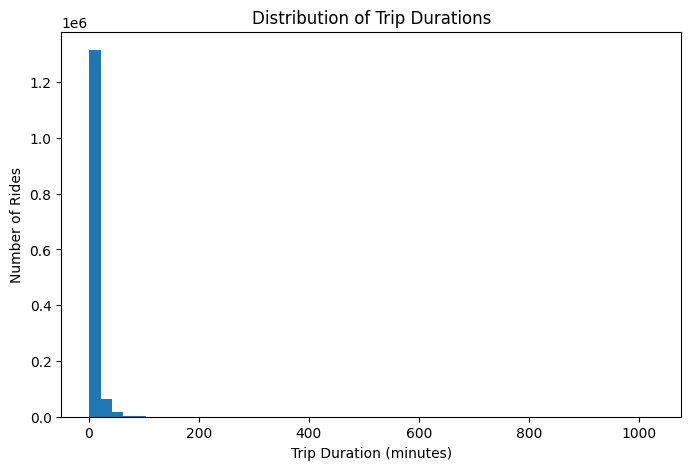

In [48]:
#Trip Duration Analsyis 
#Checking for outliers 
plt.figure(figsize=(8, 5))
plt.hist(df_all['duration']/60, bins=50)
plt.xlabel('Trip Duration (minutes)')
plt.ylabel('Number of Rides')
plt.title('Distribution of Trip Durations')
plt.show()


IQR Method for identifying outliers: 

In [50]:
#Tried the IQR metho 
Q1 = df_all['duration'].quantile(0.25)
Q3 = df_all['duration'].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = df_all[(df_all['duration'] < lower_bound) | (df_all['duration'] > upper_bound)]
print("Lower bound:", lower_bound)
print("Upper bound:", upper_bound)
print(f"Number of outliers: {len(outliers)}")
print(f"Outlier threshold (seconds): {upper_bound}")
print(f"Outlier threshold (minutes): {upper_bound/60:.2f}")


Lower bound: -273.5
Upper bound: 1282.5
Number of outliers: 89969
Outlier threshold (seconds): 1282.5
Outlier threshold (minutes): 21.38


I don't think IQR method works well with the data beings skewed to the right. 21.38 minutes seems like it would be a reasonable trip time and shouldn't be considered an outlier.

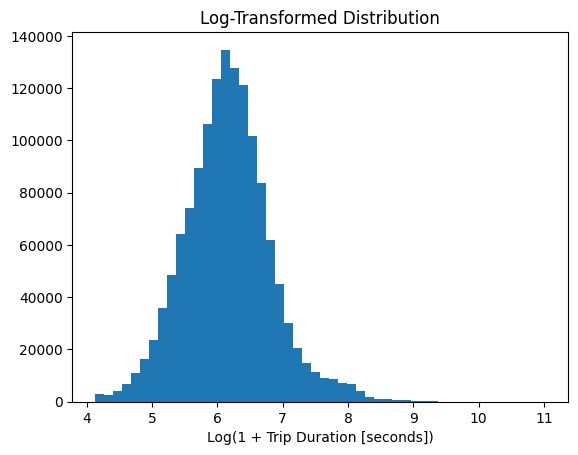

In [60]:
plt.hist(np.log1p(df_all['duration']), bins=50)
plt.xlabel('Log(1 + Trip Duration [seconds])')
plt.title('Log-Transformed Distribution')
plt.show()

Check for percentiles to find outliers: 

In [54]:
#Checking for Percentiles. 
for pct in [0.95, 0.98, 0.99, 0.995]:
    val = df_all['duration'].quantile(pct)
    print(f"{pct*100:.1f}th percentile: {val/60:.2f} minutes")



95.0th percentile: 24.30 minutes
98.0th percentile: 40.25 minutes
99.0th percentile: 52.38 minutes
99.5th percentile: 61.95 minutes


How many trips are above the 99.5th percentile? 

In [62]:
outliers = df_all[df_all['duration'] > 61.95*60]  
print(f"Number of outlier trips: {len(outliers)} ({100*len(outliers)/len(df_all):.2f}%)")



Number of outlier trips: 7016 (0.50%)


In [64]:
df_all['is_weekend'] = df_all['day_of_week'].isin([5, 6])  # Saturday=5, Sunday=6
df_all['weektype'] = df_all['is_weekend'].map({True: 'Weekend', False: 'Weekday'})

Less than 1% of trips are outliers.  Outlier trips have been identified as trips exceeding 61.95 minutes.  Outliers have been flagged and the dataframe has been filtered to exclude them from the rest of the analysis. 

In [67]:
#Flag outliers 
df_all['outlier_flag'] = df_all['duration'] > (61.95 * 60)
#create filtered df w/o outliers 
df_filtered = df_all[df_all['outlier_flag'] == False].copy()

### Historical Ride Data Analysis 

Bike usage by hour of day for 2022-2024

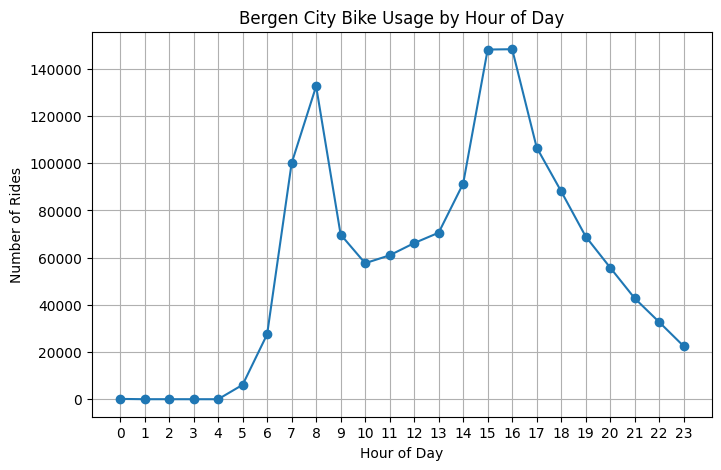

In [70]:
hour_counts = df_filtered['hour'].value_counts().sort_index()
plt.figure(figsize=(8,5))
plt.plot(hour_counts.index, hour_counts.values, marker='o')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Bergen City Bike Usage by Hour of Day')
plt.xticks(range(0,24))
plt.grid()
plt.show()


Popular ride hours: 7,8,14,15,16,17
Low ride hours: 0,1,2,3,4,5,6,20,21,22,23

Bike usage by day of week for 2022-2024:

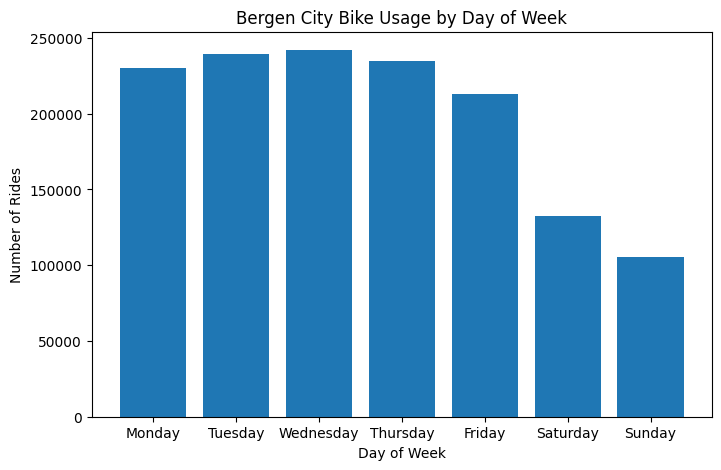

In [81]:
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

weekday_counts = df_filtered['weekday_name'].value_counts().reindex(days)
plt.figure(figsize=(8,5))
plt.bar(weekday_counts.index, weekday_counts.values)
plt.xlabel('Day of Week')
plt.ylabel('Number of Rides')
plt.title('Bergen City Bike Usage by Day of Week')
plt.show()


Weekdays are more popular then weekends.  

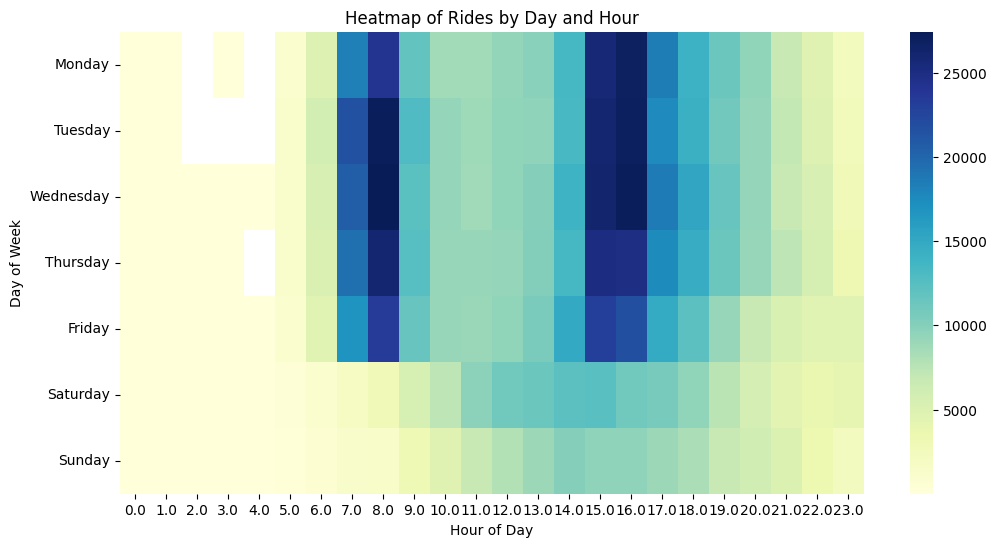

In [84]:
pivot = pd.pivot_table(
    df_filtered, 
    index='weekday_name', 
    columns='hour', 
    values='duration', 
    aggfunc='count'
).reindex(days)

plt.figure(figsize=(12,6))
sns.heatmap(pivot, cmap="YlGnBu")
plt.title('Heatmap of Rides by Day and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.show()


How many rides were taken in 2022-2024?

In [90]:
total_trips = len(df_filtered)
print("Total number of trips for 2022-2024 (excluding outliers): ", total_trips)


Total number of trips for 2022-2024 (excluding outliers):  1396602


How many rides were taken in 2024?

In [95]:
# Filter for trips in 2024
trips_2024 = df_filtered[df_filtered['year'] == 2024]

# Count total trips
total_trips_2024 = len(trips_2024)

print(f"Total trips taken in 2024: {total_trips_2024}")


Total trips taken in 2024: 398496


How many rides were taken each year? 

In [102]:
# Group by year and count trips
trips_by_year = df_filtered.groupby('year').size()

print(trips_by_year)


year
2022.0    533073
2023.0    465033
2024.0    398496
dtype: int64


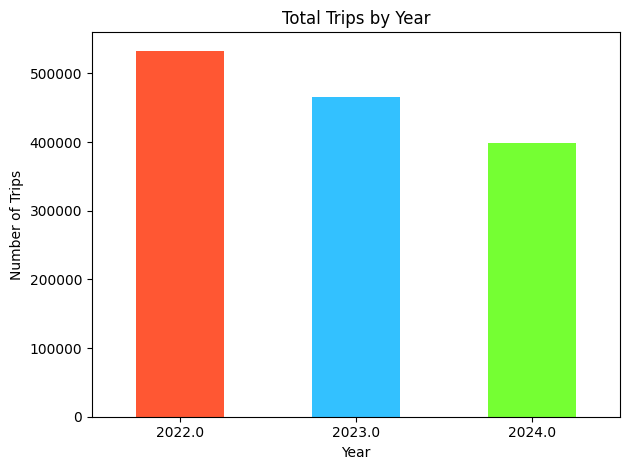

In [104]:
# Group and count trips by year
trips_by_year = df_filtered.groupby('year').size()

# Define a list of colors (one for each bar)
colors = ['#FF5733', '#33C1FF', '#75FF33', '#FF33A8', '#FFD433']  # Add more if needed

# Plot with custom colors
trips_by_year.plot(kind='bar', color=colors[:len(trips_by_year)])

plt.title('Total Trips by Year')
plt.xlabel('Year')
plt.ylabel('Number of Trips')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


The amount of rides being taken each year have declined from 2022-2024.  

In [110]:
trips_by_weekday = df_filtered['weekday_name'].value_counts().reindex(days)
print(trips_by_weekday)


weekday_name
Monday       230212
Tuesday      239123
Wednesday    241964
Thursday     234463
Friday       213028
Saturday     132465
Sunday       105347
Name: count, dtype: int64


How many rides were taken on each day in 2024?

In [112]:


# Filter for 2024 and count by weekday
trips_by_weekday_2024 = df_filtered[df_filtered['year'] == 2024]['weekday_name'].value_counts().reindex(days)

print(trips_by_weekday_2024)


weekday_name
Monday       67725
Tuesday      71100
Wednesday    70304
Thursday     66432
Friday       58629
Saturday     35473
Sunday       28833
Name: count, dtype: int64


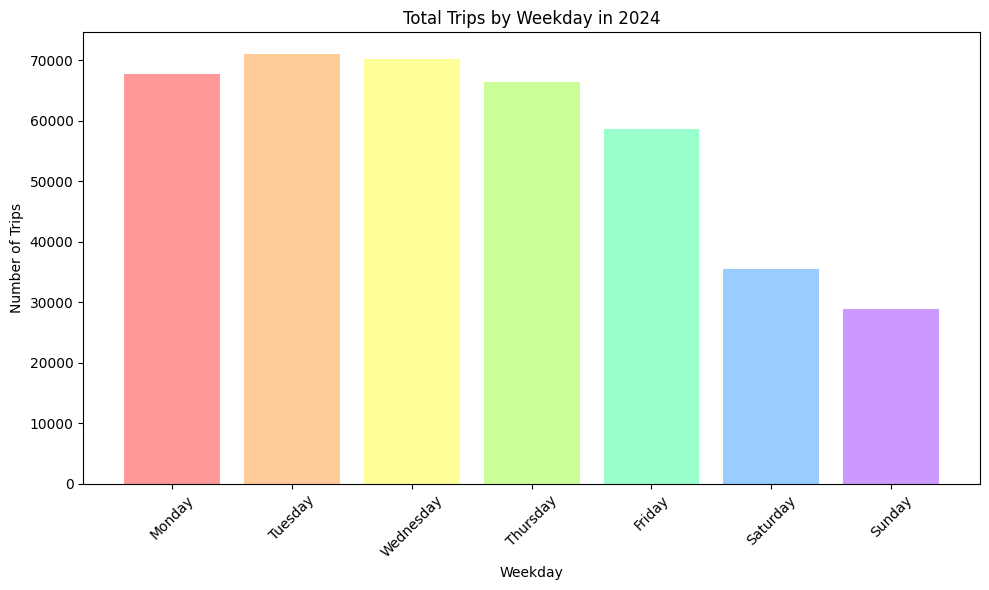

In [115]:
# Define custom colors for each day
colors = ['#FF9999', '#FFCC99', '#FFFF99', '#CCFF99', '#99FFCC', '#99CCFF', '#CC99FF']

# Plot
plt.figure(figsize=(10, 6))
plt.bar(days, trips_by_weekday_2024, color=colors)

plt.title('Total Trips by Weekday in 2024')
plt.xlabel('Weekday')
plt.ylabel('Number of Trips')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


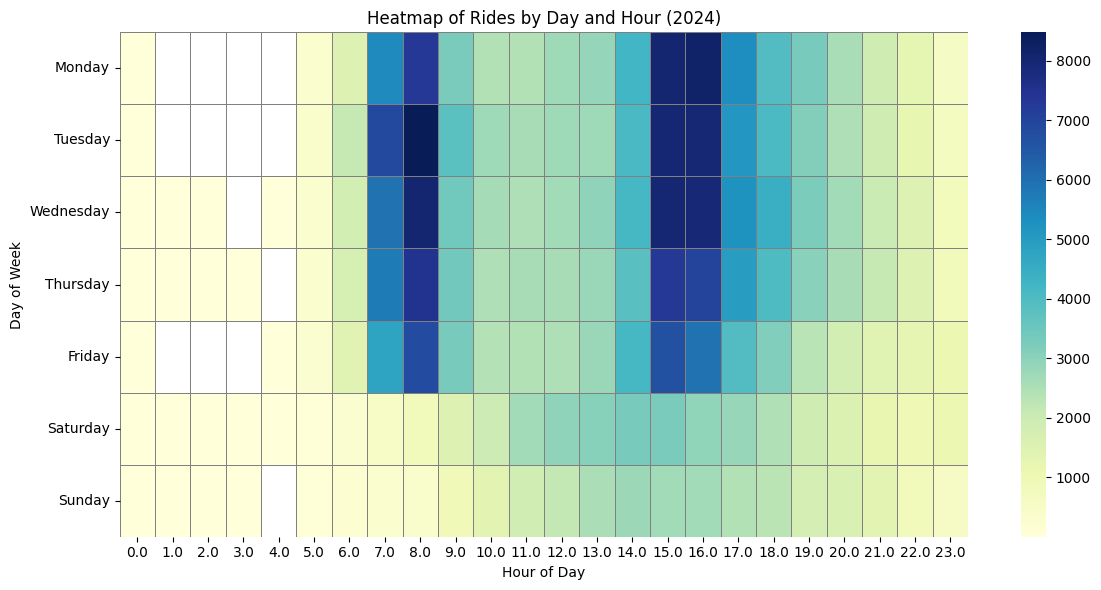

In [117]:
# Filter for 2024
df_2024 = df_filtered[df_filtered['year'] == 2024]

# Create pivot table
pivot_2024 = pd.pivot_table(
    df_2024, 
    index='weekday_name', 
    columns='hour', 
    values='duration', 
    aggfunc='count'
).reindex(days)

# Plot heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(pivot_2024, cmap="YlGnBu", linewidths=0.5, linecolor='gray')

plt.title('Heatmap of Rides by Day and Hour (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Day of Week')
plt.tight_layout()
plt.show()


In [121]:
# Filter for 2024 and weekends
df_weekend_2024 = df_filtered[
    (df_filtered['year'] == 2024) &
    (df_filtered['weekday_name'].isin(['Saturday', 'Sunday']))
]


How many rides were taken each hour, on the weekend, in 2024?

In [123]:
# Count number of rides per hour
rides_by_hour = df_weekend_2024['hour'].value_counts().sort_index()
print(rides_by_hour)


hour
0.0       23
1.0        2
2.0        3
3.0        4
4.0        1
5.0      167
6.0      482
7.0      801
8.0     1184
9.0     2445
10.0    3341
11.0    4549
12.0    5129
13.0    5611
14.0    6061
15.0    5934
16.0    5577
17.0    5271
18.0    4759
19.0    3666
20.0    3237
21.0    2558
22.0    1845
23.0    1656
Name: count, dtype: int64


What are the most and least popular ride times, on the weekend, in 2024?

In [134]:
# Define thresholds
peak_threshold = rides_by_hour.quantile(0.75)  # Top 25% of activity
low_threshold = rides_by_hour.quantile(0.25)   # Bottom 25% of activity

# Identify peak hours
peak_hours = rides_by_hour[rides_by_hour >= peak_threshold].index.tolist()

# Identify low activity hours
low_hours = rides_by_hour[rides_by_hour <= low_threshold].index.tolist()

print("Peak Hours:", peak_hours)
print("Low Activity Hours:", low_hours)


Peak Hours: [12.0, 13.0, 14.0, 15.0, 16.0, 17.0]
Low Activity Hours: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


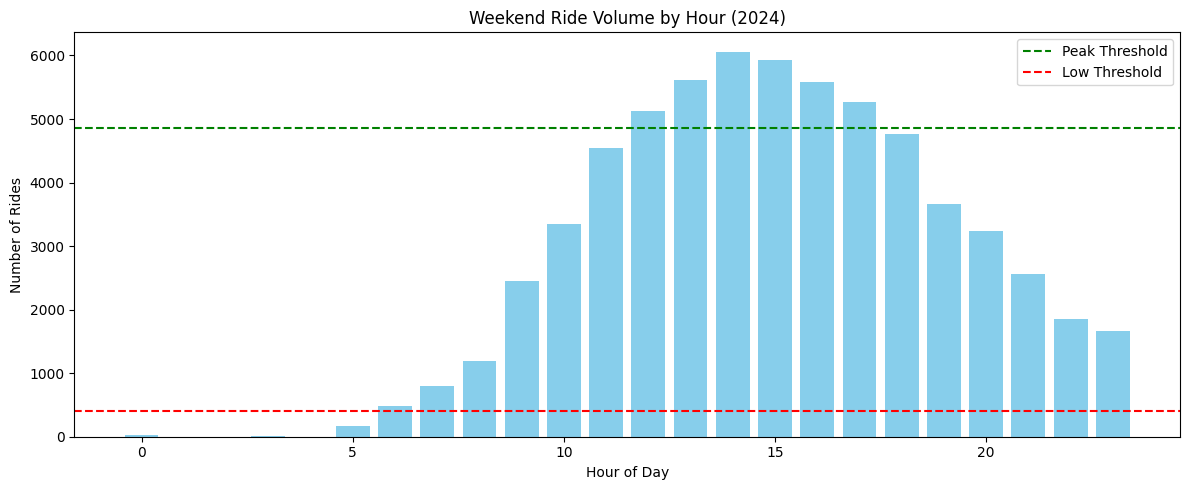

In [136]:


plt.figure(figsize=(12, 5))
plt.bar(rides_by_hour.index, rides_by_hour.values, color='skyblue')
plt.axhline(peak_threshold, color='green', linestyle='--', label='Peak Threshold')
plt.axhline(low_threshold, color='red', linestyle='--', label='Low Threshold')
plt.title('Weekend Ride Volume by Hour (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.legend()
plt.tight_layout()
plt.show()


Compare ride volume by weekend and weekday

In [143]:
# Group and count rides by weektype and hour
rides_by_hour_type = df_2024.groupby(['weektype', 'hour']).size().reset_index(name='ride_count')


WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)

WARNING - (py.warnings._showwarn

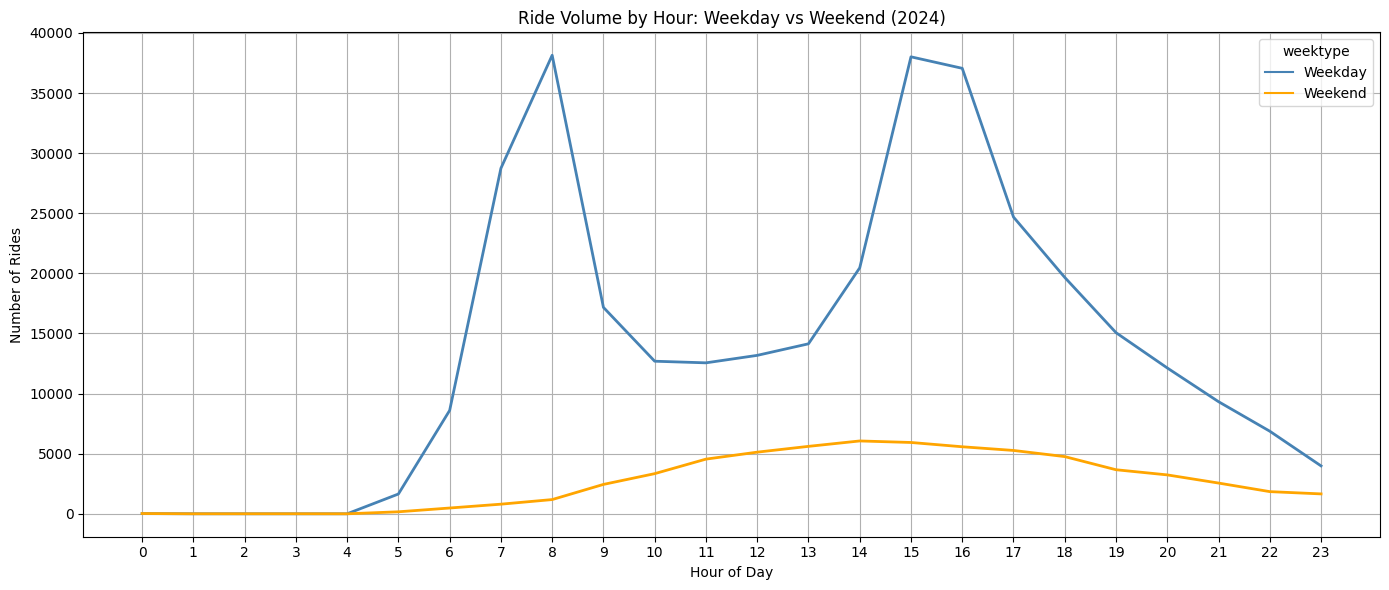

In [145]:


plt.figure(figsize=(14, 6))
sns.lineplot(data=rides_by_hour_type, x='hour', y='ride_count', hue='weektype', palette=['steelblue', 'orange'], linewidth=2)

plt.title('Ride Volume by Hour: Weekday vs Weekend (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(True)
plt.tight_layout()
plt.show()


What are the popular ride times for weekdays in 2024?

In [147]:
df_weekday_2024 = df_filtered[
    (df_filtered['year'] == 2024) & 
    (df_filtered['weektype'] == 'Weekday')
]


In [149]:
weekday_hour_counts = df_weekday_2024['hour'].value_counts().sort_index()


In [151]:
# Define thresholds
peak_threshold = weekday_hour_counts.quantile(0.75)  # Top 25%
low_threshold = weekday_hour_counts.quantile(0.25)   # Bottom 25%

# Identify hours
peak_hours = weekday_hour_counts[weekday_hour_counts >= peak_threshold].index.tolist()
low_hours = weekday_hour_counts[weekday_hour_counts <= low_threshold].index.tolist()

print("Peak Hours:", peak_hours)
print("Low Hours:", low_hours)


Peak Hours: [7.0, 8.0, 14.0, 15.0, 16.0, 17.0]
Low Hours: [0.0, 1.0, 2.0, 3.0, 4.0, 5.0]


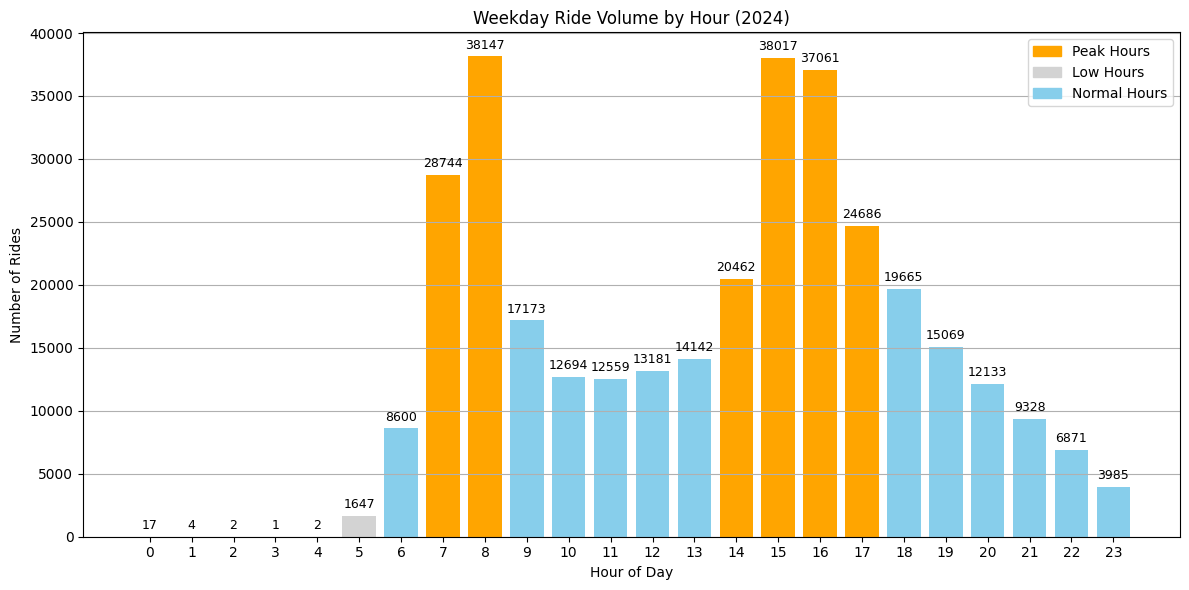

In [154]:


# Assign colors
colors = []
for hour in weekday_hour_counts.index:
    if hour in peak_hours:
        colors.append('orange')      # Peak
    elif hour in low_hours:
        colors.append('lightgray')   # Low
    else:
        colors.append('skyblue')     # Normal

# Plot
plt.figure(figsize=(12, 6))
plt.bar(weekday_hour_counts.index, weekday_hour_counts.values, color=colors)

plt.title('Weekday Ride Volume by Hour (2024)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.xticks(range(0, 24))
plt.grid(axis='y')

# Annotate bars
for hour in weekday_hour_counts.index:
    count = weekday_hour_counts[hour]
    plt.text(hour, count + max(weekday_hour_counts)*0.01, str(count), ha='center', va='bottom', fontsize=9)

# Add legend manually
import matplotlib.patches as mpatches
legend_patches = [
    mpatches.Patch(color='orange', label='Peak Hours'),
    mpatches.Patch(color='lightgray', label='Low Hours'),
    mpatches.Patch(color='skyblue', label='Normal Hours')
]
plt.legend(handles=legend_patches, loc='upper right')

plt.tight_layout()
plt.show()


Top 10 start and end stations for 2022-2024 

In [157]:
start_station_counts = df_filtered['start_station_name'].value_counts()
print(start_station_counts.head(10)) # Top 10 

end_station_counts = df_filtered['end_station_name'].value_counts()
print(end_station_counts.head(10))  # Top 10


start_station_name
Møllendalsplass        46584
Nykirken               38284
Torgallmenningen       37692
St. Jakobs Plass       35556
C. Sundts gate         29763
Festplassen            29186
Busstasjonen 1 Nord    28180
Florida Bybanestopp    26719
Torget                 25907
Thormøhlens gate       25898
Name: count, dtype: int64
end_station_name
Møllendalsplass        47181
Torgallmenningen       40380
Nykirken               38411
St. Jakobs Plass       38249
C. Sundts gate         35119
Festplassen            30922
Busstasjonen 1 Nord    30042
Florida Bybanestopp    28517
Thormøhlens gate       27416
Torget                 26694
Name: count, dtype: int64


Top start stations for 2024: 

In [160]:
start_station_counts_2024 = df_filtered[df_filtered['year'] == 2024]['start_station_name'].value_counts()
print(start_station_counts_2024.head(10))


start_station_name
Møllendalsplass              11587
Nykirken                     11345
Torgallmenningen             11239
St. Jakobs Plass              9241
Kronstad bybanestopp          8923
Busstasjonen 1 Nord           8672
C. Sundts gate                8380
Damsgårdsveien 71             8232
Solheimsgaten (ved Extra)     7843
Bergen jernbanestasjon        7828
Name: count, dtype: int64


Top end stations for 2024: 

In [163]:
end_station_counts_2024 = df_filtered[df_filtered['year'] == 2024]['end_station_name'].value_counts()
print(end_station_counts_2024.head(10))


end_station_name
Torgallmenningen          12284
Møllendalsplass           11819
Nykirken                  11360
C. Sundts gate            10697
St. Jakobs Plass          10195
Busstasjonen 1 Nord        9639
Damsgårdsveien 71          8306
Bergen jernbanestasjon     8108
Florida Bybanestopp        7854
Thormøhlens gate           7645
Name: count, dtype: int64


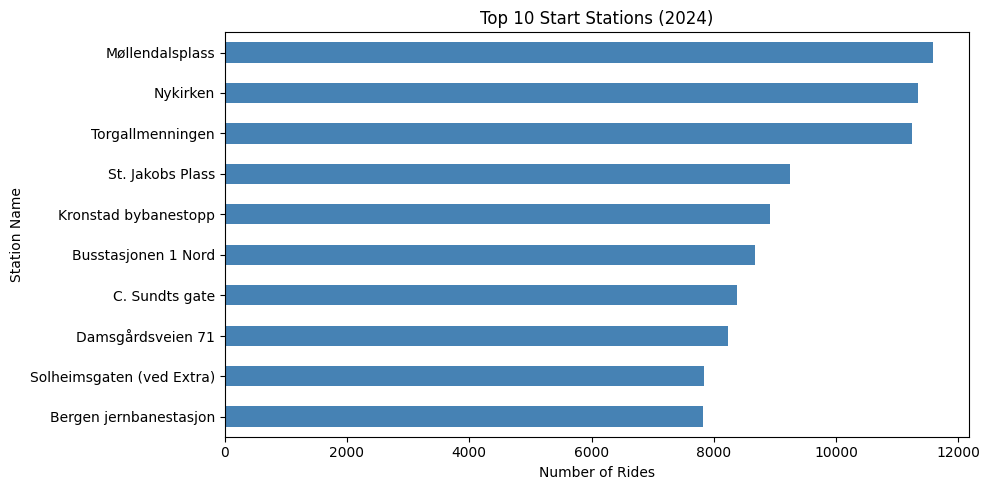

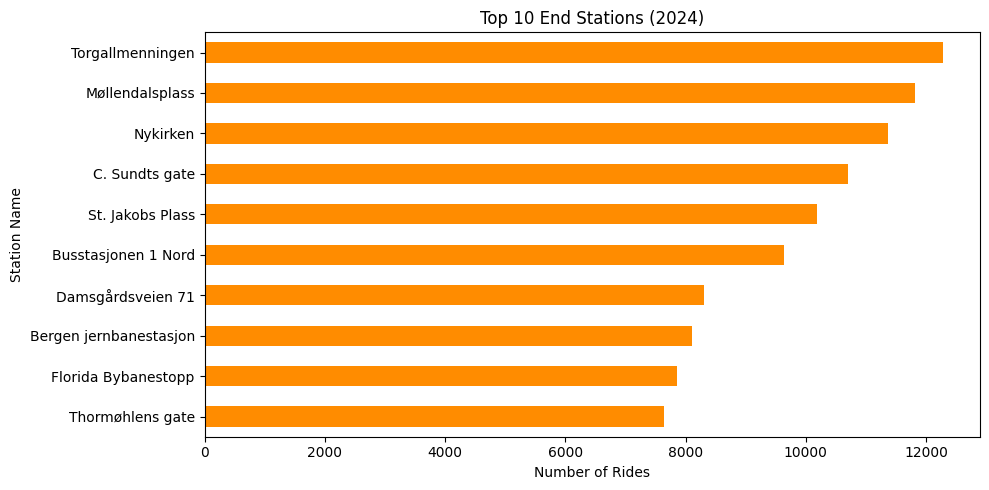

In [165]:


# Start stations
plt.figure(figsize=(10, 5))
start_station_counts_2024.head(10).plot(kind='barh', color='steelblue')
plt.title('Top 10 Start Stations (2024)')
plt.xlabel('Number of Rides')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# End stations
plt.figure(figsize=(10, 5))
end_station_counts_2024.head(10).plot(kind='barh', color='darkorange')
plt.title('Top 10 End Stations (2024)')
plt.xlabel('Number of Rides')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Top station hubs for 2022-2024

In [168]:
total_station_counts = start_station_counts.add(end_station_counts, fill_value=0)
top_hubs = total_station_counts.sort_values(ascending=False).head(10)
print(top_hubs)


Møllendalsplass        93765
Torgallmenningen       78072
Nykirken               76695
St. Jakobs Plass       73805
C. Sundts gate         64882
Festplassen            60108
Busstasjonen 1 Nord    58222
Florida Bybanestopp    55236
Thormøhlens gate       53314
Torget                 52601
Name: count, dtype: int64


Top station hubs for 2024

In [171]:


# Count starts and ends
start_counts_2024 = df_2024['start_station_name'].value_counts()
end_counts_2024 = df_2024['end_station_name'].value_counts()

# Combine counts
total_station_counts_2024 = start_counts_2024.add(end_counts_2024, fill_value=0)

# Sort and display top 10
top_hubs_2024 = total_station_counts_2024.sort_values(ascending=False).head(10)
print(top_hubs_2024)


Torgallmenningen          23523
Møllendalsplass           23406
Nykirken                  22705
St. Jakobs Plass          19436
C. Sundts gate            19077
Busstasjonen 1 Nord       18311
Damsgårdsveien 71         16538
Bergen jernbanestasjon    15936
Kronstad bybanestopp      15278
Florida Bybanestopp       15192
Name: count, dtype: int64


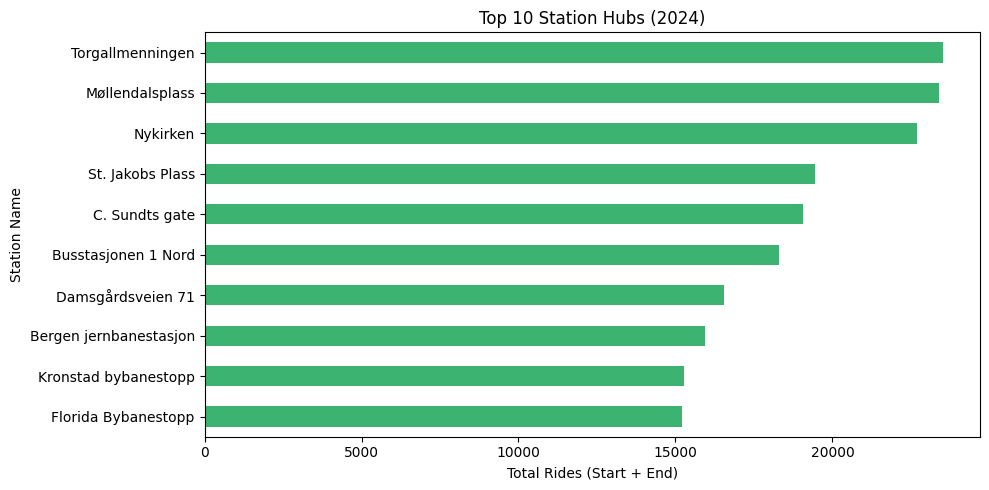

In [173]:
top_hubs_2024.plot(kind='barh', color='mediumseagreen', figsize=(10, 5))
plt.title('Top 10 Station Hubs (2024)')
plt.xlabel('Total Rides (Start + End)')
plt.ylabel('Station Name')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


Top routes for 2022-2024

In [176]:
df_filtered['route'] = df_filtered['start_station_name'] + ' → ' + df_filtered['end_station_name']


In [178]:
route_counts = df_filtered['route'].value_counts()
print(route_counts.head(10))  # Top 10 most frequent routes


route
Torgallmenningen → Nykirken                     6042
Busstasjonen 1 Nord → Møllendalsplass           5218
Torgallmenningen → C. Sundts gate               5005
Nykirken → Torgallmenningen                     4823
Møllendalsplass → Busstasjonen 1 Nord           4322
C. Sundts gate → Torgallmenningen               3453
St. Jakobs Plass → Festplassen                  2855
Thormøhlens gate → Florida Bybanestopp          2726
Østre Murallmenningen nedre → C. Sundts gate    2545
Torget → C. Sundts gate                         2543
Name: count, dtype: int64


Top routes 2024 

In [181]:
df_2024 = df_filtered[df_filtered['year'] == 2024].copy()
df_2024['route'] = df_2024['start_station_name'] + ' → ' + df_2024['end_station_name']


In [183]:
top_routes_2024 = df_2024['route'].value_counts().head(10)
print(top_routes_2024)


route
Torgallmenningen → Nykirken                     1862
Nykirken → Torgallmenningen                     1522
Kronstad bybanestopp → Studentboligene          1484
Torgallmenningen → C. Sundts gate               1444
Busstasjonen 1 Nord → Møllendalsplass           1357
C. Sundts gate → Torgallmenningen               1029
Møllendalsplass → Busstasjonen 1 Nord           1000
Thormøhlens gate → Florida Bybanestopp           897
Østre Murallmenningen nedre → C. Sundts gate     731
Torget → C. Sundts gate                          724
Name: count, dtype: int64


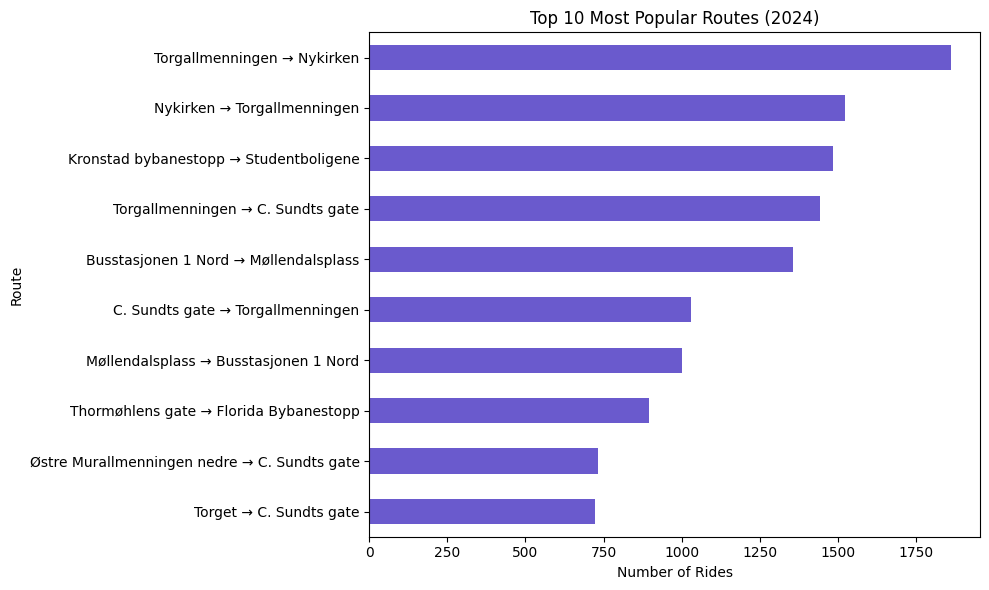

In [185]:


top_routes_2024.plot(kind='barh', color='slateblue', figsize=(10, 6))
plt.title('Top 10 Most Popular Routes (2024)')
plt.xlabel('Number of Rides')
plt.ylabel('Route')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [187]:
least_popular_starts = start_station_counts.sort_values().head(10)
print(least_popular_starts)


start_station_name
Ortun Svømmehall           126
Folke Bernadottesvei 38    140
Vestlund Borettslag        147
Lynghaug Borettslag        189
Dag Hammarskjöldsvei 73    193
Holtet Borettslag          217
Ortustranden               267
Sælen                      463
Spelhaugen                 469
Lynghaugparken             489
Name: count, dtype: int64


In [189]:
least_popular_ends = end_station_counts.sort_values().head(10)
print(least_popular_ends)


end_station_name
Vestlund Borettslag         24
Folke Bernadottesvei 38     72
Ortun Svømmehall            88
Dag Hammarskjöldsvei 73    132
Lynghaug Borettslag        161
Holtet Borettslag          202
Ortustranden               271
Sælemyr busstopp           326
Sælen                      476
Lynghaugparken             482
Name: count, dtype: int64


In [191]:
least_popular_hubs = total_station_counts.sort_values().head(10)
print(least_popular_hubs)

Vestlund Borettslag        171
Folke Bernadottesvei 38    212
Ortun Svømmehall           214
Dag Hammarskjöldsvei 73    325
Lynghaug Borettslag        350
Holtet Borettslag          419
Ortustranden               538
Sælemyr busstopp           855
Sælen                      939
Lynghaugparken             971
Name: count, dtype: int64


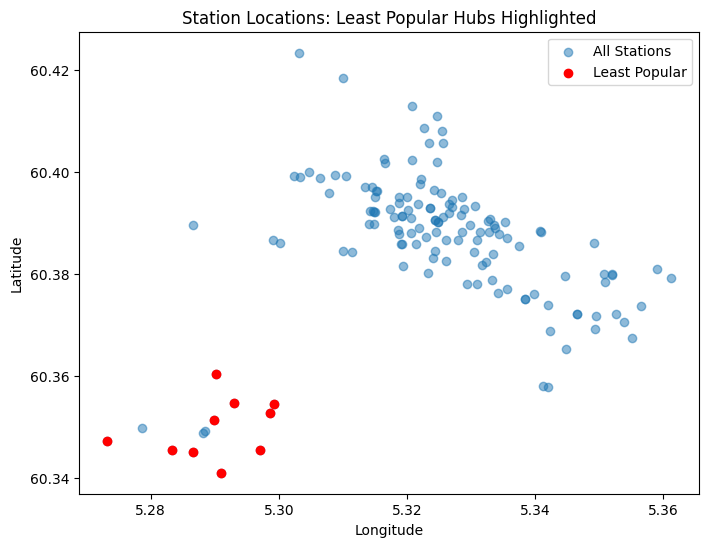

In [193]:
# Get least popular hub station names
least_hub_names = least_popular_hubs.index.tolist()

# Get unique station location pairs from start stations in your trip data
unique_stations = df_filtered[['start_station_name', 'start_station_latitude', 'start_station_longitude']].drop_duplicates()

# Filter to just the least popular hubs
low_use_stations = unique_stations[unique_stations['start_station_name'].isin(least_hub_names)]
plt.figure(figsize=(8,6))
plt.scatter(unique_stations['start_station_longitude'], unique_stations['start_station_latitude'], alpha=0.5, label='All Stations')
plt.scatter(low_use_stations['start_station_longitude'], low_use_stations['start_station_latitude'], color='red', label='Least Popular')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.title('Station Locations: Least Popular Hubs Highlighted')
plt.show()


In [195]:
# Count starts and ends
start_counts_2024 = df_2024['start_station_name'].value_counts()
end_counts_2024 = df_2024['end_station_name'].value_counts()

# Combine counts
total_station_counts_2024 = start_counts_2024.add(end_counts_2024, fill_value=0)

# Sort and get bottom 10
least_popular_hubs_2024 = total_station_counts_2024.sort_values().head(10)
print(least_popular_hubs_2024)

Folke Bernadottesvei 38     46
Ortun Svømmehall            65
Vestlund Borettslag        117
Dag Hammarskjöldsvei 73    119
Lynghaug Borettslag        139
Ortustranden               158
Sælen                      271
Lynghaugparken             282
Sælemyr busstopp           397
Holtet Borettslag          411
Name: count, dtype: int64


In [199]:
# See how many unique line coordinates there are
num_unique_lines = top_routes_unique[['start_station_latitude', 'start_station_longitude',
                                      'end_station_latitude', 'end_station_longitude']].drop_duplicates().shape[0]
print(f"Unique lines: {num_unique_lines}")


Unique lines: 10


In [201]:
loops = top_routes_unique[
    (top_routes_unique['start_station_latitude'] == top_routes_unique['end_station_latitude']) &
    (top_routes_unique['start_station_longitude'] == top_routes_unique['end_station_longitude'])
]
print("Loop routes:\n", loops)


Loop routes:
 Empty DataFrame
Columns: [route, start_station_latitude, start_station_longitude, end_station_latitude, end_station_longitude, count]
Index: []


Map of popular routes for 2022-2024:

In [205]:

# Center the map around the mean location
center_lat = top_routes_unique['start_station_latitude'].mean()
center_lon = top_routes_unique['start_station_longitude'].mean()

m = folium.Map(location=[center_lat, center_lon], zoom_start=13)

# Add stations as small circles
for _, row in top_routes_unique.iterrows():
    folium.CircleMarker(
        location=[row['start_station_latitude'], row['start_station_longitude']],
        radius=3,
        color='purple',
        fill=True,
        fill_opacity=0.8
    ).add_to(m)
    folium.CircleMarker(
        location=[row['end_station_latitude'], row['end_station_longitude']],
        radius=3,
        color='orange',
        fill=True,
        fill_opacity=0.8
    ).add_to(m)

# Draw flow lines for each top route
for _, row in top_routes_unique.iterrows():
    folium.PolyLine(
        locations=[
            [row['start_station_latitude'], row['start_station_longitude']],
            [row['end_station_latitude'], row['end_station_longitude']]
        ],
        color='blue',
        weight=row['count'] / top_routes_unique['count'].max() * 8 + 2,
        opacity=0.7,
        tooltip=f"{row['route']}: {row['count']} trips"
    ).add_to(m)

# Save to HTML and/or display inline (if in notebook)
m.save('bergen_bike_trip_flows.html')
m  # In a Jupyter notebook, this will show the map inline


Monthly ride counts: 

In [208]:
monthly_counts = df_filtered['year_month'].value_counts().sort_index()
print(monthly_counts)


year_month
2022-01    26285
2022-02    28316
2022-03    50054
2022-04    49734
2022-05    56008
2022-06    56807
2022-07    30183
2022-08    60001
2022-09    68495
2022-10    47091
2022-11    42406
2022-12    17693
2023-01    24744
2023-02    29973
2023-03    30324
2023-04    40849
2023-05    49398
2023-06    58132
2023-07    34687
2023-08    52127
2023-09    49437
2023-10    42749
2023-11    36620
2023-12    15993
2024-01    20320
2024-02    19628
2024-03    29646
2024-04    42823
2024-05    56249
2024-06    42460
2024-07    29260
2024-08    38861
2024-09    44298
2024-10    36576
2024-11    25704
2024-12    12671
Name: count, dtype: int64


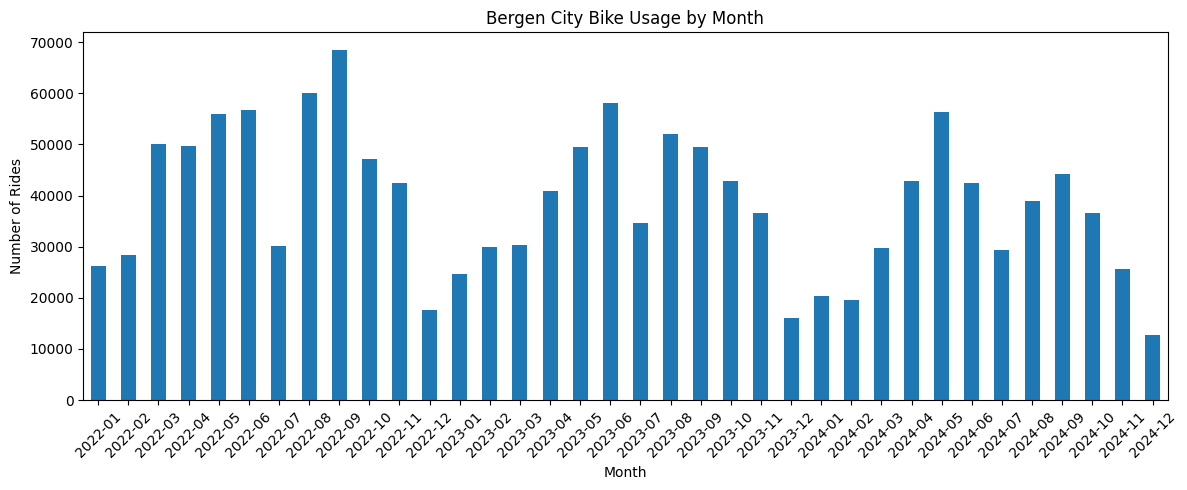

In [210]:
monthly_counts.plot(kind='bar', figsize=(12,5))
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Bergen City Bike Usage by Month')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Monthly ride counts for 2024: 

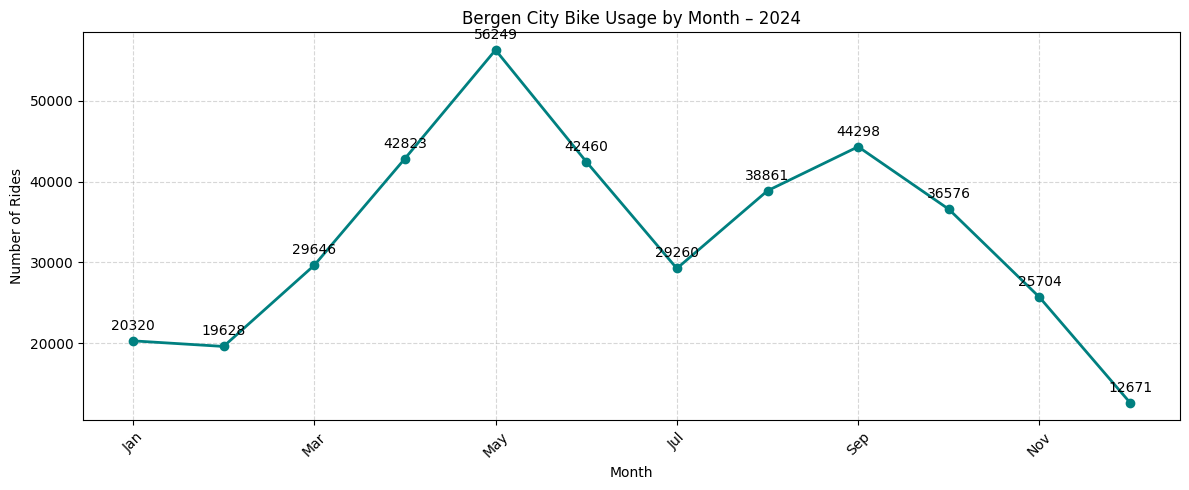

In [212]:
monthly_counts_2024 = monthly_counts[monthly_counts.index.str.startswith('2024')]

monthly_counts_2024.index = pd.to_datetime(monthly_counts_2024.index).strftime('%b')

# Plot the line chart
ax = monthly_counts_2024.plot(kind='line', marker='o', figsize=(12, 5), color='teal', linewidth=2)

# Add labels and title
plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Bergen City Bike Usage by Month – 2024')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.5)


for i, value in enumerate(monthly_counts_2024):
    ax.text(i, value + 1000, str(value), ha='center', va='bottom', fontsize=10)

plt.tight_layout()
plt.show()



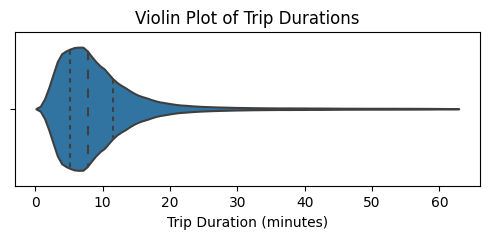

In [223]:
plt.figure(figsize=(6,2))
sns.violinplot(x=df_filtered['duration']/60, inner='quartile')
plt.xlabel('Trip Duration (minutes)')
plt.title('Violin Plot of Trip Durations')
plt.show()

Map of total rides by station: 

In [227]:
# Combine counts for each station (starts + ends)
station_counts = pd.concat([
    df_filtered[['start_station_name', 'start_station_latitude', 'start_station_longitude']].rename(
        columns={'start_station_name': 'station', 'start_station_latitude': 'lat', 'start_station_longitude': 'lon'}
    ),
    df_filtered[['end_station_name', 'end_station_latitude', 'end_station_longitude']].rename(
        columns={'end_station_name': 'station', 'end_station_latitude': 'lat', 'end_station_longitude': 'lon'}
    )
])
station_totals = station_counts['station'].value_counts()
station_counts = station_counts.drop_duplicates('station').set_index('station')
station_counts['total_rides'] = station_totals

# Make a map
center = [station_counts['lat'].mean(), station_counts['lon'].mean()]
m = folium.Map(location=center, zoom_start=13)
for station, row in station_counts.iterrows():
    folium.CircleMarker(
        location=[row['lat'], row['lon']],
        radius=3 + row['total_rides']/station_counts['total_rides'].max()*20,  # size by rides
        color='blue',
        fill=True,
        fill_opacity=0.6,
        popup=f"{station}: {row['total_rides']} rides"
    ).add_to(m)
m.save('stations_map.html')
m  # Shows inline in Jupyter Notebook


Monthly rides by week type: 

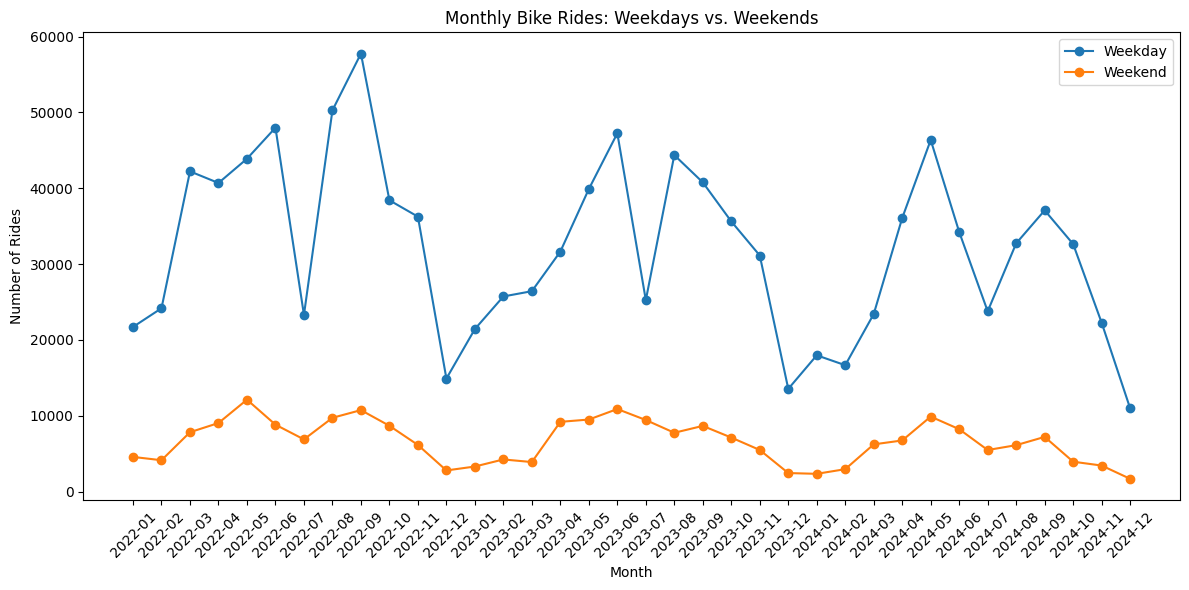

In [234]:
monthly_by_weektype = df_filtered.groupby(['year_month', 'weektype']).size().reset_index(name='rides')

plt.figure(figsize=(12,6))
for typ in ['Weekday', 'Weekend']:
    subset = monthly_by_weektype[monthly_by_weektype['weektype'] == typ]
    plt.plot(subset['year_month'], subset['rides'], marker='o', label=typ)

plt.xlabel('Month')
plt.ylabel('Number of Rides')
plt.title('Monthly Bike Rides: Weekdays vs. Weekends')
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



Rides per hour by weekend and weekday: 

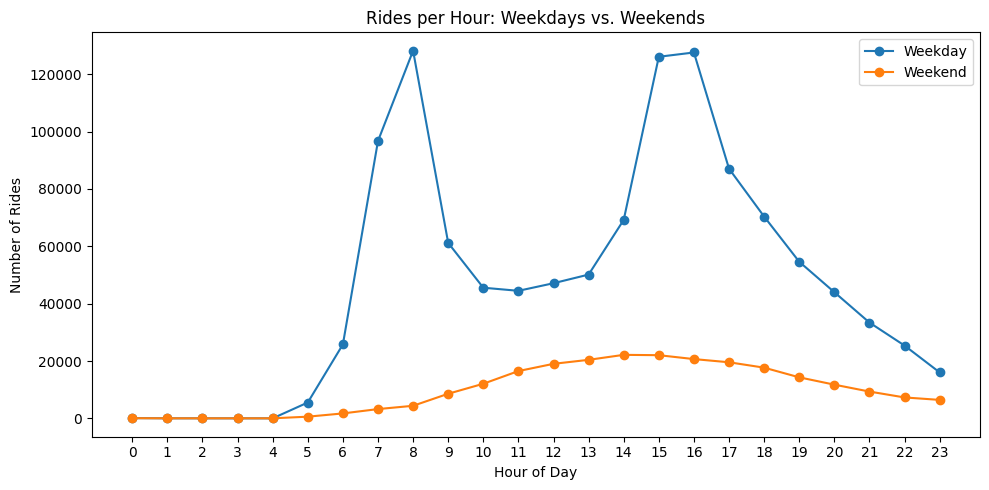

In [237]:
hourly_by_weektype = df_filtered.groupby(['hour', 'weektype']).size().reset_index(name='rides')

plt.figure(figsize=(10,5))
for typ in ['Weekday', 'Weekend']:
    subset = hourly_by_weektype[hourly_by_weektype['weektype'] == typ]
    plt.plot(subset['hour'], subset['rides'], marker='o', label=typ)

plt.xlabel('Hour of Day')
plt.ylabel('Number of Rides')
plt.title('Rides per Hour: Weekdays vs. Weekends')
plt.xticks(range(0,24))
plt.legend()
plt.tight_layout()
plt.show()


## Time Series Analysis 

### Time Series Forecast (Holt-Winters) 

1. Split data into train and test set 

In [253]:
df_filtered['year_month'] = pd.to_datetime(df_filtered['year_month'])
monthly = df_filtered.groupby('year_month').size()
monthly = monthly.to_frame(name='ride_count')

In [255]:
series = monthly['ride_count']
train = series[:-6]
test = series[-6:]


In [258]:
series.index.freq = 'MS'

2. Check for best parameters to run the model 

In [260]:
# Define parameter grids
trend_types = ['add', 'mul', None]
seasonal_types = ['add', 'mul']
seasonal_periods = [12]  # For monthly data
damped_trends = [True, False]

best_score = float('inf')
best_params = {}
results = []

# Create all combinations of parameters
param_combinations = list(itertools.product(
    trend_types, seasonal_types, seasonal_periods, damped_trends
))

for trend, seasonal, periods, damped in param_combinations:
    # Skip invalid combinations
    if trend is None and damped:
        continue
        
    try:
        # Create and fit model
        model = ExponentialSmoothing(
            train,
            trend=trend,
            seasonal=seasonal,
            seasonal_periods=periods,
            damped_trend=damped,
            initialization_method='estimated'
        )
        model_fit = model.fit(method='Powell', use_brute=False)
        
        # Generate predictions and calculate error
        predictions = model_fit.forecast(len(test))
        mae = mean_absolute_error(test, predictions)
        
        # Store results
        results.append({
            'trend': trend,
            'seasonal': seasonal,
            'damped': damped,
            'mae': mae,
            'aic': model_fit.aic
        })
        
        # Track best model
        if mae < best_score:
            best_score = mae
            best_params = {
                'trend': trend, 
                'seasonal': seasonal,
                'damped': damped
            }
            
    except Exception as e:
        print(f"Error with params {trend}, {seasonal}, {damped}: {str(e)}")

# Convert results to DataFrame and sort
results_df = pd.DataFrame(results).sort_values('mae')
print("Best parameters:", best_params)
print("\nTop 5 models:")
print(results_df.head())

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)

WARNING - (p

Best parameters: {'trend': 'mul', 'seasonal': 'mul', 'damped': False}

Top 5 models:
  trend seasonal  damped          mae         aic
7   mul      mul   False  3741.627653  528.157182
3   add      mul   False  3835.470357  528.311407
1   add      add   False  5257.880258  528.884535
5   mul      add   False  5479.454124  528.779446
0   add      add    True  5555.617427  530.759899


Run the model based on the best parameters 

WARNING - (py.warnings._showwarnmsg) - /opt/anaconda3/lib/python3.11/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)



Validation Metrics (Test Period):
  MAE : 3741.6 rides/month
  RMSE: 4558.0 rides/month
  MAPE: 12.3%

Future Monthly Ride Forecast:
            predicted_rides
2025-01-01          17725.0
2025-02-01          19425.0
2025-03-01          27744.0
2025-04-01          33008.0
2025-05-01          39696.0
2025-06-01          39135.0
2025-07-01          23137.0
2025-08-01          37808.0
2025-09-01          40691.0
2025-10-01          31407.0
2025-11-01          26295.0
2025-12-01          11557.0


NameError: name 'mdates' is not defined

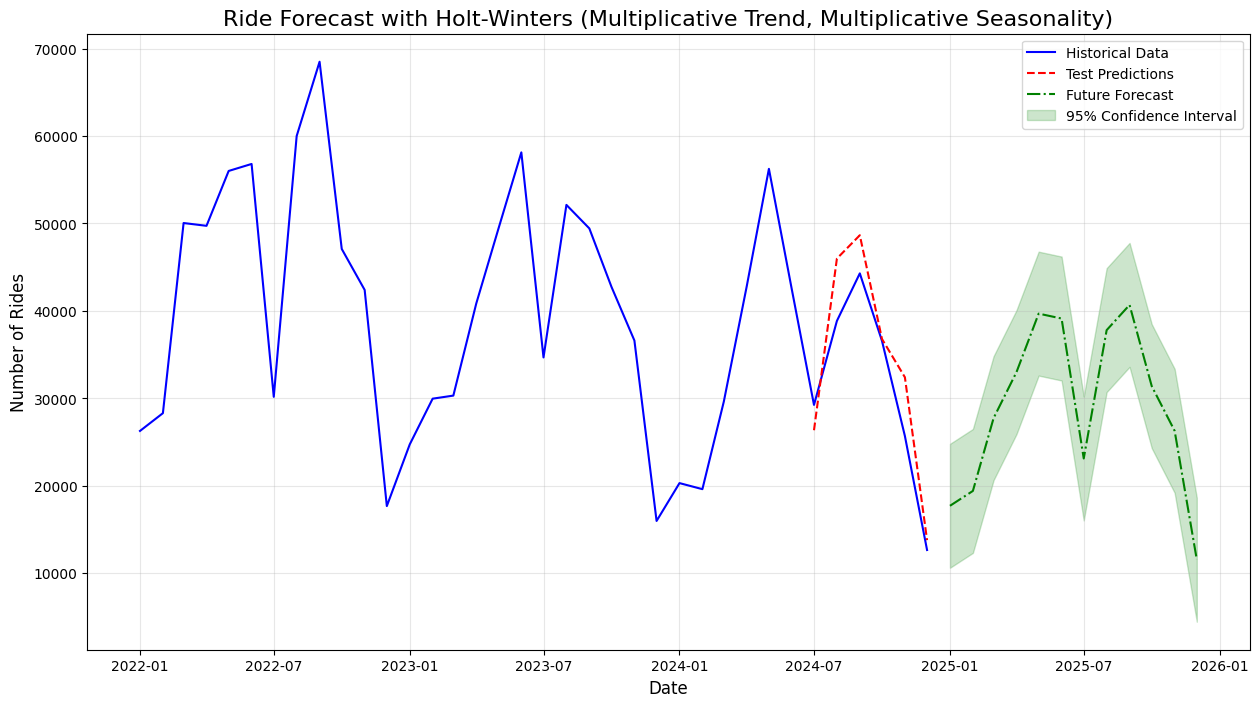

In [268]:
# 1. Fit the best model (multiplicative trend, multiplicative seasonality)
best_model = ExponentialSmoothing(
    train,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12,
    initialization_method='estimated'
)
best_fit = best_model.fit(method='Powell', use_brute=False)

# 2. Generate forecasts for test period
pred = best_fit.forecast(len(test))
pred.index = test.index

# 3. Calculate error metrics
mae = mean_absolute_error(test, pred)
mse = mean_squared_error(test, pred)
rmse = np.sqrt(mse)
nonzero_test = test[test != 0]
nonzero_pred = pred[nonzero_test.index]
mape = np.mean(np.abs((nonzero_test - nonzero_pred) / nonzero_test)) * 100


print("Validation Metrics (Test Period):")
print(f"  MAE : {mae:.1f} rides/month")
print(f"  RMSE: {rmse:.1f} rides/month")
print(f"  MAPE: {mape:.1f}%\n")

# 4. Fit model on full data for future forecasting
full_model = ExponentialSmoothing(
    monthly,
    trend='mul',
    seasonal='mul',
    seasonal_periods=12,
    initialization_method='estimated'
)
full_fit = full_model.fit(method='Powell', use_brute=False)

# 5. Generate future forecasts (12 months ahead)
future_periods = 12
forecast = full_fit.forecast(future_periods)
forecast.index = pd.date_range(
    start=monthly.index[-1] + pd.offsets.MonthBegin(),
    periods=future_periods, 
    freq='MS'
)

print("Future Monthly Ride Forecast:")
forecast_df = forecast.to_frame('predicted_rides')
print(forecast_df.round(0))

# 6. Create visualizations
plt.figure(figsize=(15, 8))

# Plot historical data
plt.plot(monthly, label='Historical Data', color='blue')

# Plot test predictions
plt.plot(pred, label='Test Predictions', color='red', linestyle='--')

# Plot future forecast
plt.plot(forecast, label='Future Forecast', color='green', linestyle='-.')

# Add confidence intervals for future forecast (approximate)
# Using standard error from test predictions
std_err = np.std(test - pred)
plt.fill_between(
    forecast.index,
    forecast - 1.96 * std_err,
    forecast + 1.96 * std_err,
    color='green', alpha=0.2,
    label='95% Confidence Interval'
)

# Add styling
plt.title('Ride Forecast with Holt-Winters (Multiplicative Trend, Multiplicative Seasonality)', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Number of Rides', fontsize=12)
plt.grid(True, alpha=0.3)
plt.legend(loc='best')

# Format x-axis to show months and years clearly
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=3))
plt.xticks(rotation=45)

# Add annotations for metrics
metrics_text = f"Test Metrics:\nMAE: {mae:.1f}\nRMSE: {rmse:.1f}\nMAPE: {mape:.1f}%"
plt.annotate(metrics_text, xy=(0.02, 0.95), xycoords='axes fraction',
             bbox=dict(boxstyle="round,pad=0.5", fc="white", alpha=0.8))

plt.tight_layout()

# Create a second visualization showing components
plt.figure(figsize=(15, 10))

# Get the components (level, trend, seasonal)
result = full_fit.summary_frame()

# Plot in subplots
fig, axes = plt.subplots(4, 1, figsize=(15, 12), sharex=True)

# Original data and fitted values
axes[0].plot(monthly, label='Original Data')
axes[0].plot(result['fitted'], label='Fitted Values', color='red')
axes[0].set_title('Original Data vs Fitted Values')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Level component
axes[1].plot(result['level'], label='Level')
axes[1].set_title('Level Component')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

# Trend component
axes[2].plot(result['trend'], label='Trend')
axes[2].set_title('Trend Component')
axes[2].legend()
axes[2].grid(True, alpha=0.3)

# Seasonal component
axes[3].plot(result['season'], label='Seasonality')
axes[3].set_title('Seasonal Component')
axes[3].legend()
axes[3].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print model parameters
print("\nModel Parameters:")
print(f"Smoothing Level (alpha): {best_fit.params['smoothing_level']:.4f}")
print(f"Smoothing Trend (beta): {best_fit.params['smoothing_trend']:.4f}")
print(f"Smoothing Seasonal (gamma): {best_fit.params['smoothing_seasonal']:.4f}")

Holt-Winters model had an MAPE score of 12.3%, meaning the forecasted values may be off by 12.3%.  Going to run Prophet model to see if outpeforms the Holt-Winters model. 

### Prophet Modeling 

In [276]:
prophet_df = monthly.reset_index()
prophet_df.columns = ['ds', 'y']



In [278]:
print(prophet_df.head())
print(prophet_df.dtypes)


          ds      y
0 2022-01-01  26285
1 2022-02-01  28316
2 2022-03-01  50054
3 2022-04-01  49734
4 2022-05-01  56008
ds    datetime64[ns]
y              int64
dtype: object


In [ ]:
print(prophet_df.dtypes)


In [282]:
from prophet import Prophet
from prophet.diagnostics import cross_validation, performance_metrics
import itertools
from sklearn.metrics import mean_squared_error

Prophet Model Code Steps - 
1.Calculate the ratio of weekdays (Mon–Fri) in each month.
2.Split data into train/test
3.Hyperparameter tuning 
4.Choose paremeter set with lowest MAE score 
5.Forecast future demand 

Number of combinations: 40


17:52:44 - cmdstanpy - INFO - Chain [1] start processing
17:52:45 - cmdstanpy - INFO - Chain [1] done processing
17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:51 - cmdstanpy - INFO - Chain [1] done processing
17:52:51 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}, MAE: 9569.78, RMSE: 9767.41, MAPE: 0.42%


17:52:51 - cmdstanpy - INFO - Chain [1] start processing
17:52:52 - cmdstanpy - INFO - Chain [1] done processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:55 - cmdstanpy - INFO - Chain [1] start processing
17:52:56 - cmdstanpy - INFO - Chain [1] done processing
17:52:58 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, MAE: 10211.87, RMSE: 10335.49, MAPE: 0.45%


17:52:59 - cmdstanpy - INFO - Chain [1] start processing
17:53:01 - cmdstanpy - INFO - Chain [1] done processing
17:53:04 - cmdstanpy - INFO - Chain [1] start processing
17:53:04 - cmdstanpy - INFO - Chain [1] start processing
17:53:05 - cmdstanpy - INFO - Chain [1] done processing
17:53:06 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}, MAE: 3486.95, RMSE: 3593.46, MAPE: 0.14%


17:53:06 - cmdstanpy - INFO - Chain [1] start processing
17:53:07 - cmdstanpy - INFO - Chain [1] done processing
17:53:10 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] start processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing
17:53:11 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, MAE: 3730.26, RMSE: 3804.95, MAPE: 0.14%


17:53:12 - cmdstanpy - INFO - Chain [1] start processing
17:53:12 - cmdstanpy - INFO - Chain [1] done processing
17:53:15 - cmdstanpy - INFO - Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] start processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing
17:53:15 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}, MAE: 4296.51, RMSE: 4296.90, MAPE: 0.17%


17:53:16 - cmdstanpy - INFO - Chain [1] start processing
17:53:16 - cmdstanpy - INFO - Chain [1] done processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:19 - cmdstanpy - INFO - Chain [1] start processing
17:53:20 - cmdstanpy - INFO - Chain [1] done processing
17:53:20 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, MAE: 4414.83, RMSE: 4426.78, MAPE: 0.16%


17:53:20 - cmdstanpy - INFO - Chain [1] start processing
17:53:22 - cmdstanpy - INFO - Chain [1] done processing
17:53:25 - cmdstanpy - INFO - Chain [1] start processing
17:53:25 - cmdstanpy - INFO - Chain [1] start processing
17:53:26 - cmdstanpy - INFO - Chain [1] done processing
17:53:26 - cmdstanpy - INFO - Chain [1] done processing
17:53:26 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}, MAE: 5926.64, RMSE: 6093.14, MAPE: 0.23%


17:53:27 - cmdstanpy - INFO - Chain [1] done processing
17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] start processing
17:53:30 - cmdstanpy - INFO - Chain [1] done processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.001, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}, MAE: 5314.96, RMSE: 5341.01, MAPE: 0.19%


17:53:31 - cmdstanpy - INFO - Chain [1] start processing
17:53:31 - cmdstanpy - INFO - Chain [1] done processing
17:53:34 - cmdstanpy - INFO - Chain [1] start processing
17:53:34 - cmdstanpy - INFO - Chain [1] start processing
17:53:34 - cmdstanpy - INFO - Chain [1] done processing
17:53:35 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}, MAE: 9651.21, RMSE: 9841.63, MAPE: 0.43%


17:53:35 - cmdstanpy - INFO - Chain [1] start processing
17:53:35 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] start processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing
17:53:38 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, MAE: 10037.33, RMSE: 10170.97, MAPE: 0.44%


17:53:39 - cmdstanpy - INFO - Chain [1] start processing
17:53:39 - cmdstanpy - INFO - Chain [1] done processing
17:53:42 - cmdstanpy - INFO - Chain [1] start processing
17:53:42 - cmdstanpy - INFO - Chain [1] start processing
17:53:42 - cmdstanpy - INFO - Chain [1] done processing
17:53:42 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}, MAE: 3539.61, RMSE: 3635.26, MAPE: 0.14%


17:53:43 - cmdstanpy - INFO - Chain [1] start processing
17:53:43 - cmdstanpy - INFO - Chain [1] done processing
17:53:46 - cmdstanpy - INFO - Chain [1] start processing
17:53:46 - cmdstanpy - INFO - Chain [1] start processing
17:53:46 - cmdstanpy - INFO - Chain [1] done processing
17:53:46 - cmdstanpy - INFO - Chain [1] done processing
17:53:47 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, MAE: 3765.07, RMSE: 3830.48, MAPE: 0.14%


17:53:47 - cmdstanpy - INFO - Chain [1] done processing
17:53:49 - cmdstanpy - INFO - Chain [1] start processing
17:53:49 - cmdstanpy - INFO - Chain [1] start processing
17:53:50 - cmdstanpy - INFO - Chain [1] done processing
17:53:50 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}, MAE: 4376.71, RMSE: 4384.17, MAPE: 0.17%


17:53:50 - cmdstanpy - INFO - Chain [1] start processing
17:53:51 - cmdstanpy - INFO - Chain [1] done processing
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
17:53:53 - cmdstanpy - INFO - Chain [1] start processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing
17:53:54 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, MAE: 4312.84, RMSE: 4313.65, MAPE: 0.16%


17:53:54 - cmdstanpy - INFO - Chain [1] start processing
17:53:55 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing
17:53:58 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}, MAE: 6301.52, RMSE: 6514.72, MAPE: 0.26%


17:53:58 - cmdstanpy - INFO - Chain [1] start processing
17:53:59 - cmdstanpy - INFO - Chain [1] done processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:01 - cmdstanpy - INFO - Chain [1] start processing
17:54:02 - cmdstanpy - INFO - Chain [1] done processing
17:54:02 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.01, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}, MAE: 6022.36, RMSE: 6080.86, MAPE: 0.22%


17:54:02 - cmdstanpy - INFO - Chain [1] start processing
17:54:03 - cmdstanpy - INFO - Chain [1] done processing
17:54:06 - cmdstanpy - INFO - Chain [1] start processing
17:54:06 - cmdstanpy - INFO - Chain [1] start processing
17:54:06 - cmdstanpy - INFO - Chain [1] done processing
17:54:06 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}, MAE: 9621.01, RMSE: 9788.48, MAPE: 0.42%


17:54:07 - cmdstanpy - INFO - Chain [1] start processing
17:54:08 - cmdstanpy - INFO - Chain [1] done processing
17:54:11 - cmdstanpy - INFO - Chain [1] start processing
17:54:11 - cmdstanpy - INFO - Chain [1] start processing
17:54:11 - cmdstanpy - INFO - Chain [1] done processing
17:54:11 - cmdstanpy - INFO - Chain [1] done processing
17:54:12 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, MAE: 10048.52, RMSE: 10180.33, MAPE: 0.44%


17:54:12 - cmdstanpy - INFO - Chain [1] done processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:15 - cmdstanpy - INFO - Chain [1] start processing
17:54:16 - cmdstanpy - INFO - Chain [1] done processing
17:54:16 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}, MAE: 3548.24, RMSE: 3640.69, MAPE: 0.14%


17:54:16 - cmdstanpy - INFO - Chain [1] start processing
17:54:17 - cmdstanpy - INFO - Chain [1] done processing
17:54:20 - cmdstanpy - INFO - Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] start processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing
17:54:20 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, MAE: 3776.24, RMSE: 3841.34, MAPE: 0.14%


17:54:21 - cmdstanpy - INFO - Chain [1] start processing
17:54:21 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] start processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing
17:54:25 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}, MAE: 4378.84, RMSE: 4385.68, MAPE: 0.17%


17:54:26 - cmdstanpy - INFO - Chain [1] start processing
17:54:26 - cmdstanpy - INFO - Chain [1] done processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:29 - cmdstanpy - INFO - Chain [1] start processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:30 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, MAE: 4539.87, RMSE: 4540.84, MAPE: 0.17%


17:54:30 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] start processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing
17:54:33 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}, MAE: 6371.20, RMSE: 6587.64, MAPE: 0.26%


17:54:34 - cmdstanpy - INFO - Chain [1] start processing
17:54:34 - cmdstanpy - INFO - Chain [1] done processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] start processing
17:54:37 - cmdstanpy - INFO - Chain [1] done processing
17:54:38 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.05, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}, MAE: 6315.00, RMSE: 6394.63, MAPE: 0.24%


17:54:39 - cmdstanpy - INFO - Chain [1] start processing
17:54:39 - cmdstanpy - INFO - Chain [1] done processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] start processing
17:54:41 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:42 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}, MAE: 9633.06, RMSE: 9800.83, MAPE: 0.42%


17:54:42 - cmdstanpy - INFO - Chain [1] done processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] start processing
17:54:45 - cmdstanpy - INFO - Chain [1] done processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, MAE: 10035.92, RMSE: 10167.82, MAPE: 0.44%


17:54:46 - cmdstanpy - INFO - Chain [1] start processing
17:54:46 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:50 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}, MAE: 3550.39, RMSE: 3642.62, MAPE: 0.14%


17:54:50 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing
17:54:53 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, MAE: 3774.19, RMSE: 3839.31, MAPE: 0.14%


17:54:53 - cmdstanpy - INFO - Chain [1] start processing
17:54:54 - cmdstanpy - INFO - Chain [1] done processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] start processing
17:54:56 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] done processing
17:54:57 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}, MAE: 4382.99, RMSE: 4390.16, MAPE: 0.17%


17:54:58 - cmdstanpy - INFO - Chain [1] done processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] start processing
17:55:00 - cmdstanpy - INFO - Chain [1] done processing
17:55:01 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, MAE: 4639.92, RMSE: 4642.59, MAPE: 0.17%


17:55:01 - cmdstanpy - INFO - Chain [1] start processing
17:55:02 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] start processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing
17:55:04 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}, MAE: 6375.69, RMSE: 6589.39, MAPE: 0.26%


17:55:05 - cmdstanpy - INFO - Chain [1] start processing
17:55:05 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] start processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:08 - cmdstanpy - INFO - Chain [1] done processing
17:55:09 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.1, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}, MAE: 6401.71, RMSE: 6490.31, MAPE: 0.25%


17:55:09 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] start processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing
17:55:12 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'additive'}, MAE: 12390.67, RMSE: 12676.78, MAPE: 0.54%


17:55:13 - cmdstanpy - INFO - Chain [1] start processing
17:55:13 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] done processing
17:55:16 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.01, 'seasonality_mode': 'multiplicative'}, MAE: 12922.66, RMSE: 13188.88, MAPE: 0.56%


17:55:17 - cmdstanpy - INFO - Chain [1] done processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:19 - cmdstanpy - INFO - Chain [1] start processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:20 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}, MAE: 3420.67, RMSE: 3494.59, MAPE: 0.14%


17:55:20 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] done processing
17:55:23 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'multiplicative'}, MAE: 5201.83, RMSE: 5373.31, MAPE: 0.17%


17:55:24 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] start processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing
17:55:27 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'additive'}, MAE: 4334.79, RMSE: 4358.94, MAPE: 0.17%


17:55:28 - cmdstanpy - INFO - Chain [1] start processing
17:55:28 - cmdstanpy - INFO - Chain [1] done processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:30 - cmdstanpy - INFO - Chain [1] start processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing
17:55:31 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 1.0, 'seasonality_mode': 'multiplicative'}, MAE: 5196.50, RMSE: 5204.96, MAPE: 0.18%


17:55:31 - cmdstanpy - INFO - Chain [1] start processing
17:55:32 - cmdstanpy - INFO - Chain [1] done processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] start processing
17:55:34 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] done processing
17:55:35 - cmdstanpy - INFO - Chain [1] start processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'additive'}, MAE: 7107.25, RMSE: 7466.44, MAPE: 0.30%


17:56:01 - cmdstanpy - INFO - Chain [1] done processing
17:56:04 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] start processing
17:56:04 - cmdstanpy - INFO - Chain [1] done processing
17:56:26 - cmdstanpy - INFO - Chain [1] done processing


Finished evaluating {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 10.0, 'seasonality_mode': 'multiplicative'}, MAE: 10333.39, RMSE: 10413.65, MAPE: 0.35%

Best parameters: {'changepoint_prior_scale': 0.5, 'seasonality_prior_scale': 0.1, 'seasonality_mode': 'additive'}
Best MAE: 3420.67


17:56:26 - cmdstanpy - INFO - Chain [1] start processing
17:56:27 - cmdstanpy - INFO - Chain [1] done processing



Improved Prophet Test-Set Metrics (Jul–Dec 2024)
 MAE : 1853.9 rides/month
 RMSE: 2170.4 rides/month
 MAPE: 7.3%



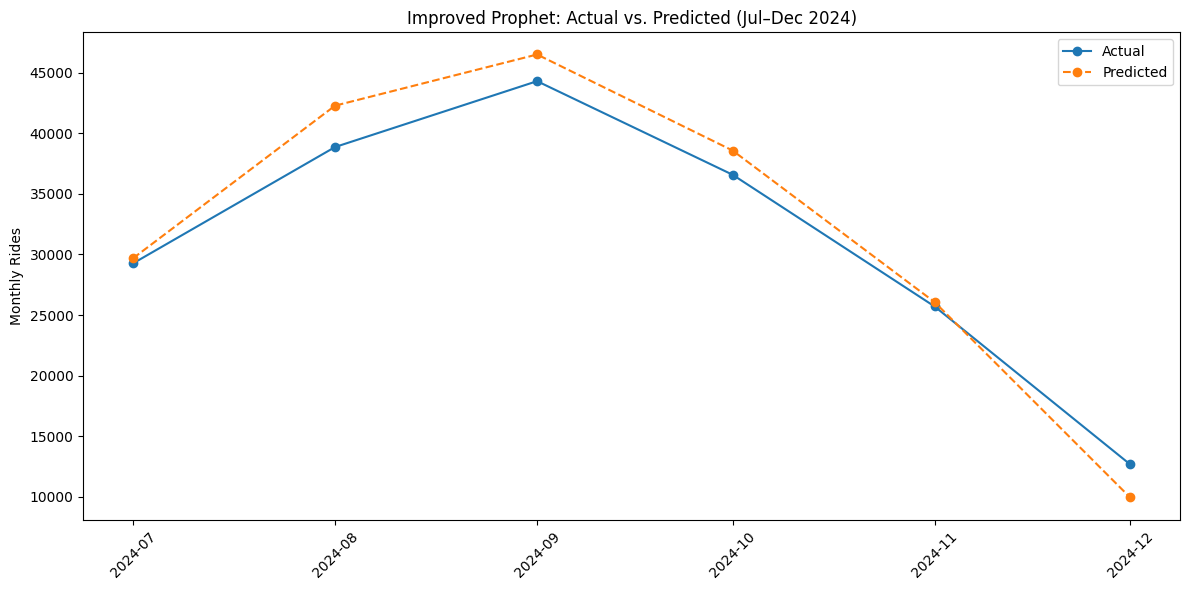

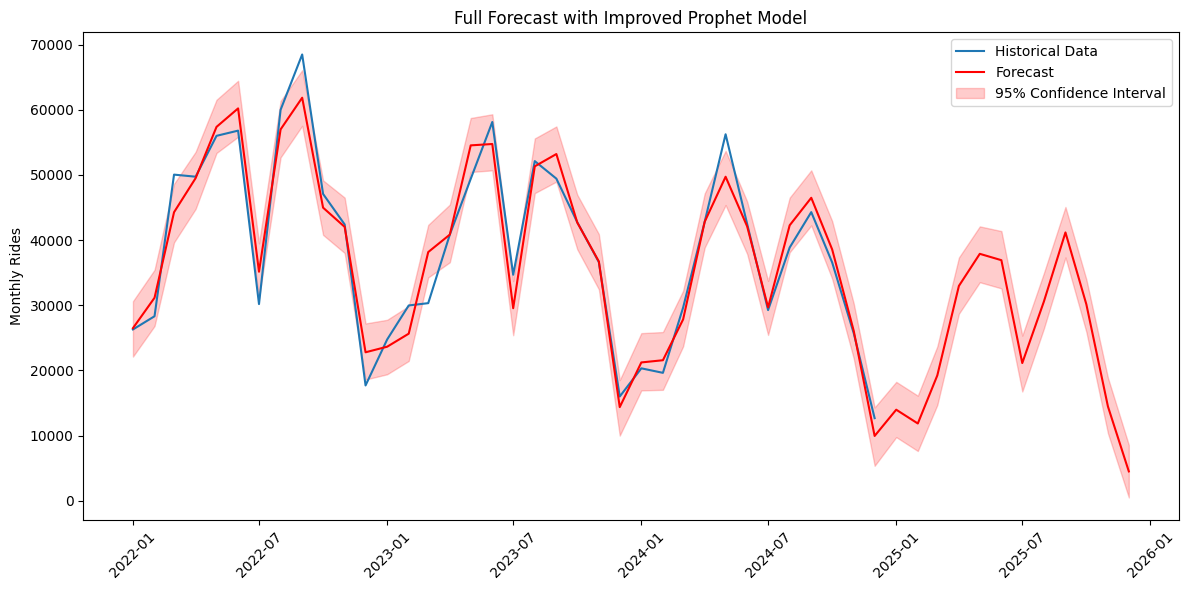

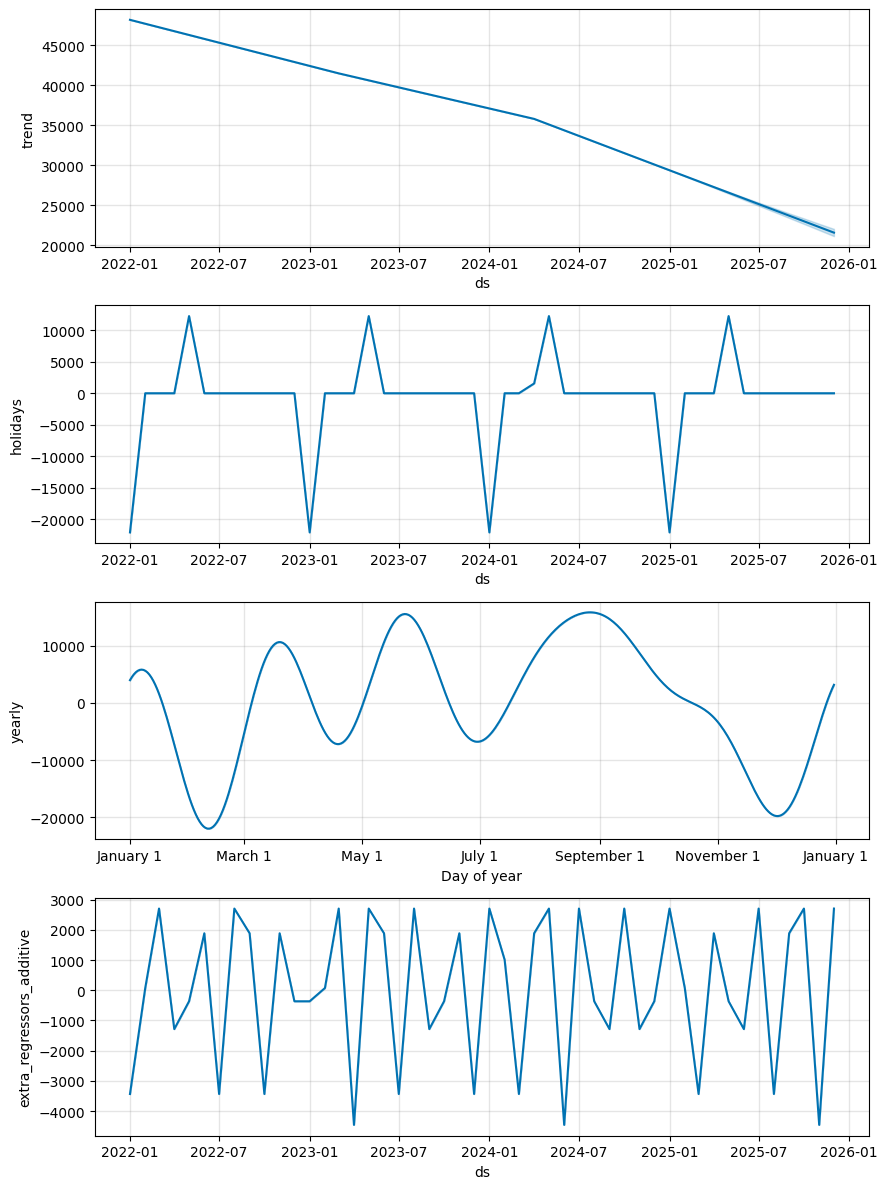


Forecast for next 12 months:
               yhat  yhat_lower  yhat_upper
ds                                         
2025-01-01  13970.0      9761.0     18244.0
2025-02-01  11853.0      7627.0     16124.0
2025-03-01  19233.0     14699.0     23687.0
2025-04-01  32970.0     28696.0     37331.0
2025-05-01  37896.0     33535.0     42108.0
2025-06-01  36920.0     32594.0     41391.0
2025-07-01  21130.0     16763.0     25340.0
2025-08-01  30557.0     26411.0     34934.0
2025-09-01  41179.0     37344.0     45089.0
2025-10-01  30149.0     25913.0     33981.0
2025-11-01  14469.0     10353.0     18873.0
2025-12-01   4499.0       496.0      8562.0


In [285]:
# Calculate the proportion of weekdays in each month
def weekday_proportion(date):
    """Calculate proportion of weekdays in a month"""
    month_start = pd.Timestamp(date.year, date.month, 1)
    if date.month == 12:
        month_end = pd.Timestamp(date.year + 1, 1, 1) - pd.Timedelta(days=1)
    else:
        month_end = pd.Timestamp(date.year, date.month + 1, 1) - pd.Timedelta(days=1)
    
    days = pd.date_range(month_start, month_end)
    weekdays = [d.weekday() < 5 for d in days]  # Monday-Friday are 0-4
    return sum(weekdays) / len(days)


# Add weekday proportion regressor
prophet_df['weekday_ratio'] = prophet_df['ds'].apply(weekday_proportion)

#Split into Train/Test
split_date = '2024-07-01'
train_df = prophet_df[prophet_df['ds'] <  split_date].copy()
test_df  = prophet_df[prophet_df['ds'] >= split_date].copy()

# Define parameter grid for hyperparameter tuning
param_grid = {
    'changepoint_prior_scale': [0.001, 0.01, 0.05, 0.1, 0.5],
    'seasonality_prior_scale': [0.01, 0.1, 1.0, 10.0],
    'seasonality_mode': ['additive', 'multiplicative']
}

# Generate all combinations of parameters
all_params = [dict(zip(param_grid.keys(), v)) for v in itertools.product(*param_grid.values())]
print(f"Number of combinations: {len(all_params)}")

# Storage for results
results = []

# Use cross validation to evaluate all parameters
for params in all_params:
    # Create and fit model with current parameter combination
    m = Prophet(
        changepoint_prior_scale=params['changepoint_prior_scale'],
        seasonality_prior_scale=params['seasonality_prior_scale'],
        seasonality_mode=params['seasonality_mode'],
        yearly_seasonality=6,
        weekly_seasonality=False,
        daily_seasonality=False
    )
    
    # Add Norwegian holidays
    m.add_country_holidays(country_name='Norway')
    
    # Add weekday ratio regressor
    m.add_regressor('weekday_ratio')
    
    # Fit the model
    m.fit(train_df)
    
    # Cross-validate
    df_cv = cross_validation(
        m, initial='540 days', period='90 days', horizon='180 days', parallel='processes'
    )
    
    # Compute performance metrics
    df_p = performance_metrics(df_cv)
    
    # Get the mean values of the metrics
    mae = df_p['mae'].mean()
    rmse = df_p['rmse'].mean()
    mape = df_p['mape'].mean()
    
    # Save results
    results.append({
        'params': params,
        'mae': mae,
        'rmse': rmse,
        'mape': mape
    })
    
    print(f"Finished evaluating {params}, MAE: {mae:.2f}, RMSE: {rmse:.2f}, MAPE: {mape:.2f}%")

# Find the best parameters
results_df = pd.DataFrame(results)
best_params = results_df.loc[results_df['mae'].idxmin(), 'params']
print(f"\nBest parameters: {best_params}")
print(f"Best MAE: {results_df['mae'].min():.2f}")

# Create final model with best parameters
final_model = Prophet(
    changepoint_prior_scale=best_params['changepoint_prior_scale'],
    seasonality_prior_scale=best_params['seasonality_prior_scale'],
    seasonality_mode=best_params['seasonality_mode'],
    yearly_seasonality=6,
    weekly_seasonality=False,
    daily_seasonality=False
)
final_model.add_country_holidays(country_name='Norway')
final_model.add_regressor('weekday_ratio')
final_model.fit(prophet_df)

# Create future dataframe for prediction
future = final_model.make_future_dataframe(periods=12, freq='MS')
# Add weekday ratio to future dataframe
future['weekday_ratio'] = future['ds'].apply(weekday_proportion)

# Make predictions
forecast = final_model.predict(future)

# Evaluate on test set
test_forecast = forecast[forecast['ds'].isin(test_df['ds'])]
test_actual = test_df.set_index('ds')['y']
test_predicted = test_forecast.set_index('ds')['yhat']

# Calculate metrics
mae = mean_absolute_error(test_actual, test_predicted)
mse = mean_squared_error(test_actual, test_predicted)
rmse = np.sqrt(mse)
mape = (abs((test_actual - test_predicted)/test_actual)).mean() * 100

print("\nImproved Prophet Test-Set Metrics (Jul–Dec 2024)")
print(f" MAE : {mae:.1f} rides/month")
print(f" RMSE: {rmse:.1f} rides/month")
print(f" MAPE: {mape:.1f}%\n")

# Plot results
plt.figure(figsize=(12,6))
plt.plot(test_actual.index, test_actual.values, label='Actual', marker='o')
plt.plot(test_predicted.index, test_predicted.values, label='Predicted', linestyle='--', marker='o')
plt.title("Improved Prophet: Actual vs. Predicted (Jul–Dec 2024)")
plt.ylabel("Monthly Rides")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Plot full forecast
plt.figure(figsize=(12,6))
plt.plot(prophet_df['ds'], prophet_df['y'], label='Historical Data')
plt.plot(forecast['ds'], forecast['yhat'], label='Forecast', color='red')
plt.fill_between(forecast['ds'], 
                 forecast['yhat_lower'], 
                 forecast['yhat_upper'], 
                 color='red', 
                 alpha=0.2, 
                 label='95% Confidence Interval')
plt.title("Full Forecast with Improved Prophet Model")
plt.ylabel("Monthly Rides")
plt.legend()
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Show forecast components
fig = final_model.plot_components(forecast)
plt.show()

# Print future predictions
future_forecast = forecast[~forecast['ds'].isin(prophet_df['ds'])]
print("\nForecast for next 12 months:")
print(future_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].set_index('ds').round(0))

In [287]:
# Sum predicted rides for the next 12 months
total_predicted_rides = future_forecast['yhat'].sum()
print(f"Total Predicted Rides for 2025: {total_predicted_rides:,.0f}")


Total Predicted Rides for 2025: 294,825
